In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from datetime import datetime

In [2]:
df_filtered = pd.read_excel("./Filtered_dataset_Employee turnover.xlsx")

In [ ]:
df_filtered.info()

In [4]:
# Convert object features into categorical

# Employee status
employee_status_categories = ['Active', 'Discarded', 'Dormant', 'Terminated', 'Unpaid Leave']

# Convert the 'Feature' column to a categorical type with predefined categories
df_filtered['Employee Status'] = pd.Categorical(df_filtered['Employee Status'], categories = employee_status_categories, ordered=False)

In [5]:
df_filtered.loc[:, 'Employee Type'] = df_filtered['Employee Type'].astype('category')

In [6]:
df_filtered['Age_Group'] = pd.cut(df_filtered['Employee Age'], bins=[0, 30, 40, 50, 60, 100], labels=['0-30', '30-40', '40-50', '50-60', '60+'])
df_filtered['Age_Group_Codes'] = df_filtered['Age_Group'].cat.codes

In [7]:
# Create features of the mean performance/objective/competency ratings per user throughout the years
# Calculate mean ratings for performance, competency, and objective
years = ['2017', '2018', '2019', '2020', '2021', '2022', '2023']

df_filtered['Mean_performance'] = df_filtered[[f"Overall Performance Rating {year}" for year in years if f"Overall Performance Rating {year}" in df_filtered.columns]].mean(axis=1)
df_filtered['Mean_competency'] = df_filtered[[f"Overall Competency Rating {year}" for year in years if f"Overall Competency Rating {year}" in df_filtered.columns]].mean(axis=1)
df_filtered['Mean_objective'] = df_filtered[[f"Overall Objective Rating {year}" for year in years if f"Overall Objective Rating {year}" in df_filtered.columns]].mean(axis=1)


In [ ]:
df_filtered.info()

## Logistic Regression

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, f1_score, accuracy_score

# List of years and rating types
years = ['2017', '2018', '2019', '2020', '2021', '2022', '2023']
rating_types = ['Overall Competency Rating', 'Overall Objective Rating', 'Overall Performance Rating']

# Selecting features for each year
features = []
for year in years:
    for rating_type in rating_types:
        col_name = f"{rating_type} {year}"
        if col_name in df_filtered.columns:
            features.append(col_name)

# Additional features assumed to be in your DataFrame
additional_features = ['Gender_x', 'Age_Group_Codes', 'Employment Details Regret Termination', 'Average Performance per Age Group']

# Combine all features
X_features = features + additional_features

# Defining independent variables (features)
X = df_filtered[X_features]

# Defining the target variable
y = df_filtered['Employee Status'].apply(lambda x: 1 if x == 'Terminated' else 0)

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define pipeline
pipeline_lr = ImbPipeline([
    ('smote', SMOTE(random_state=42)),
    ('classifier', LogisticRegression(random_state=42))
])

# Parameters grid
param_grid_lr = {
    'classifier__C': [0.01, 0.1, 1, 10, 100],
    'classifier__penalty': ['l1', 'l2'],
    'classifier__solver': ['liblinear', 'saga']  # These solvers can handle L1 penalty
}

# Setup grid search
grid_search_lr = GridSearchCV(pipeline_lr, param_grid_lr, cv=10, scoring='f1')
grid_search_lr.fit(X_train, y_train)

# Best model
best_lr_model = grid_search_lr.best_estimator_

### Prediction on Train Data

In [10]:
# Predict on training data
train_pred_lr = best_lr_model.predict(X_train)

# Evaluate accuracy and F1-score on training data
train_accuracy_lr = accuracy_score(y_train, train_pred_lr)
train_f1_lr = f1_score(y_train, train_pred_lr)

print("Training Data Accuracy:", train_accuracy_lr)
print("Training Data F1 Score:", train_f1_lr)


Training Data Accuracy: 0.9744763490081843
Training Data F1 Score: 0.962046204620462


### Prediction on Test Data

In [11]:
# Predict on test data
y_pred_lr = best_lr_model.predict(X_test)

# Evaluate accuracy and F1-score on test data
test_accuracy_lr = accuracy_score(y_test, y_pred_lr)
test_f1_lr = f1_score(y_test, y_pred_lr)

print("Test Data Accuracy:", test_accuracy_lr)
print("Test Data F1 Score:", test_f1_lr)
print(classification_report(y_test, y_pred_lr))

Test Data Accuracy: 0.9739323349972269
Test Data F1 Score: 0.9633099141295862
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      1180
           1       0.94      0.99      0.96       623

    accuracy                           0.97      1803
   macro avg       0.97      0.98      0.97      1803
weighted avg       0.98      0.97      0.97      1803



In [12]:
# Calculate Kohen's Cappa - baseline LR
from sklearn.metrics import cohen_kappa_score
kappa_lr = cohen_kappa_score(y_test, y_pred_lr)
print("Cohen's Kappa Score:", kappa_lr)


Cohen's Kappa Score: 0.9431182561125002


### Missclasification Report

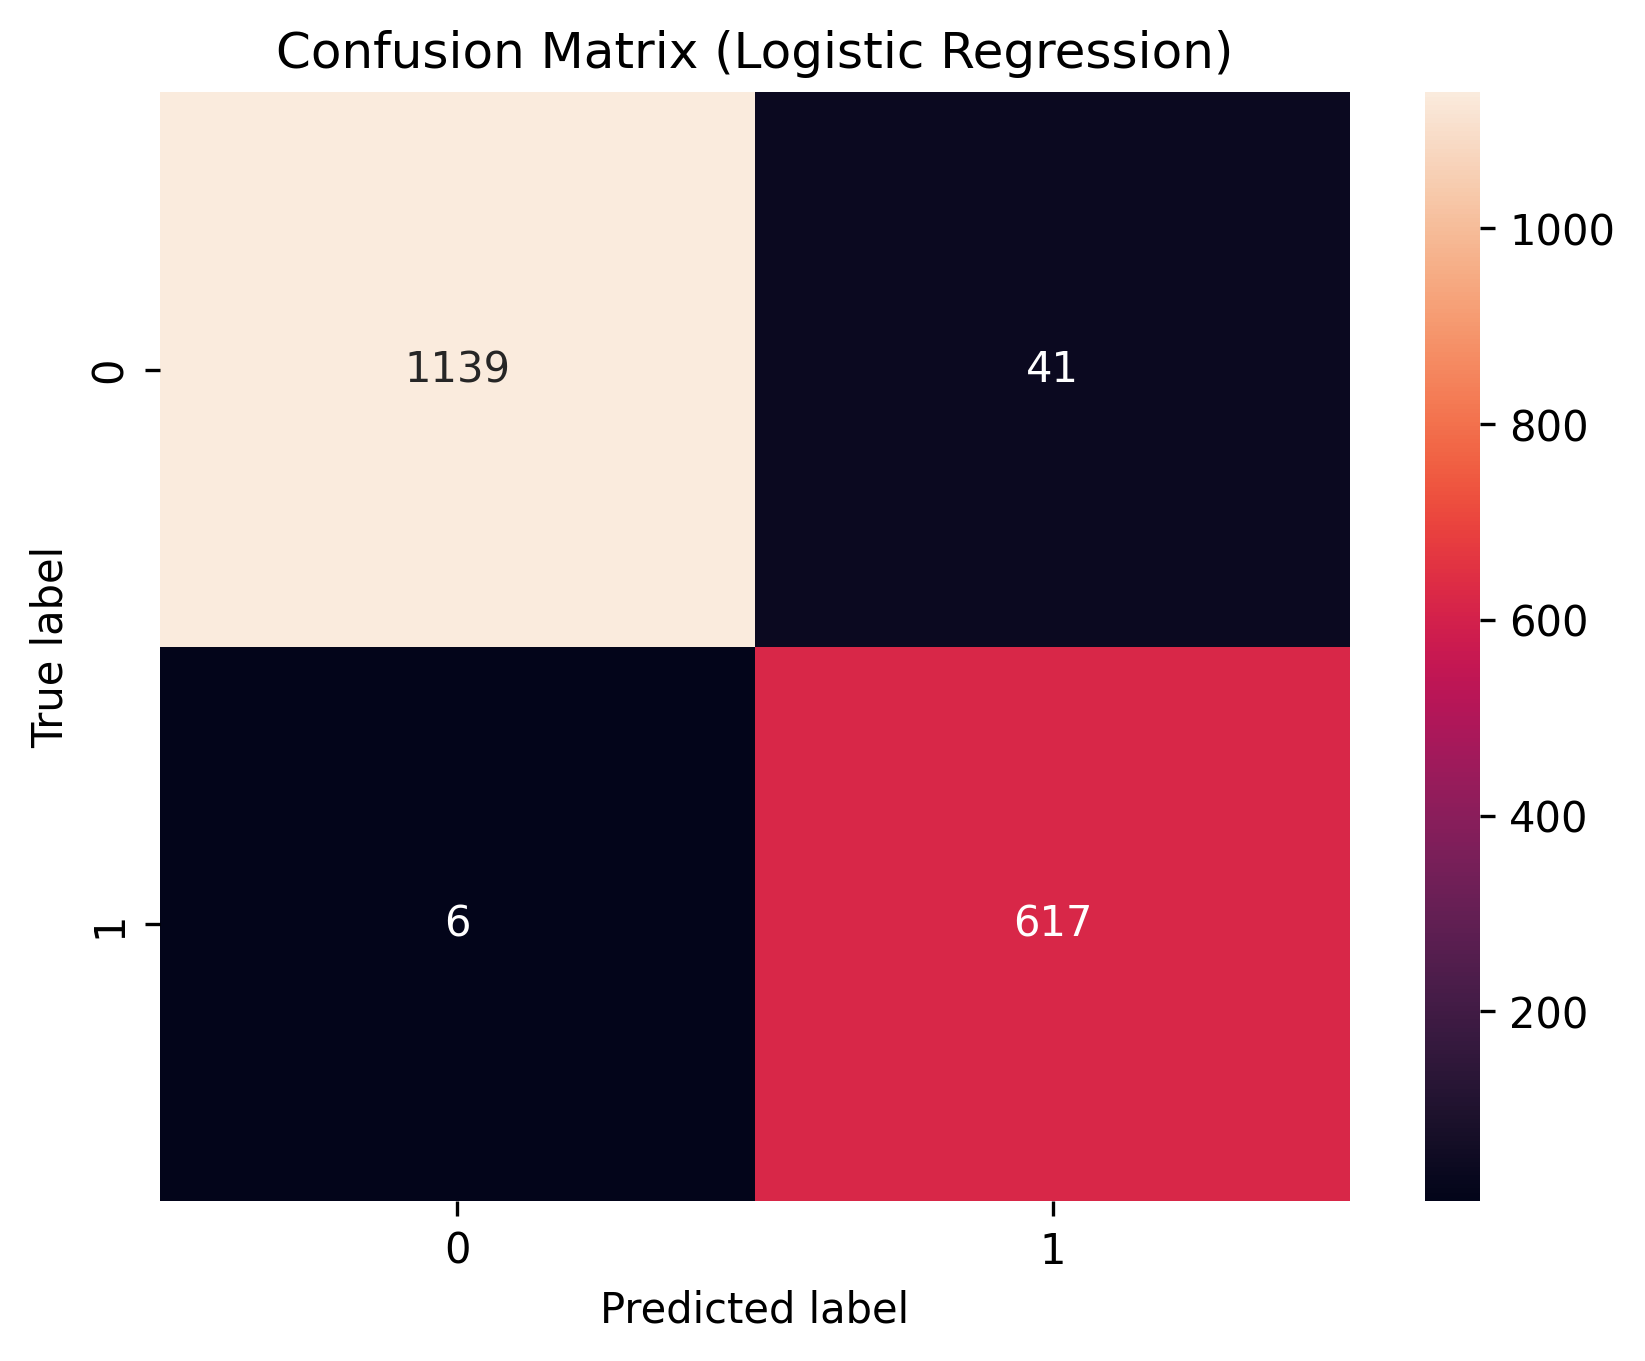

In [86]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm_lr = confusion_matrix(y_test, y_pred_lr)
plt.figure(dpi=300)
sns.heatmap(cm_lr, annot=True, fmt="d")
plt.title('Confusion Matrix (Logistic Regression)')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

### Feature Importance Analysis

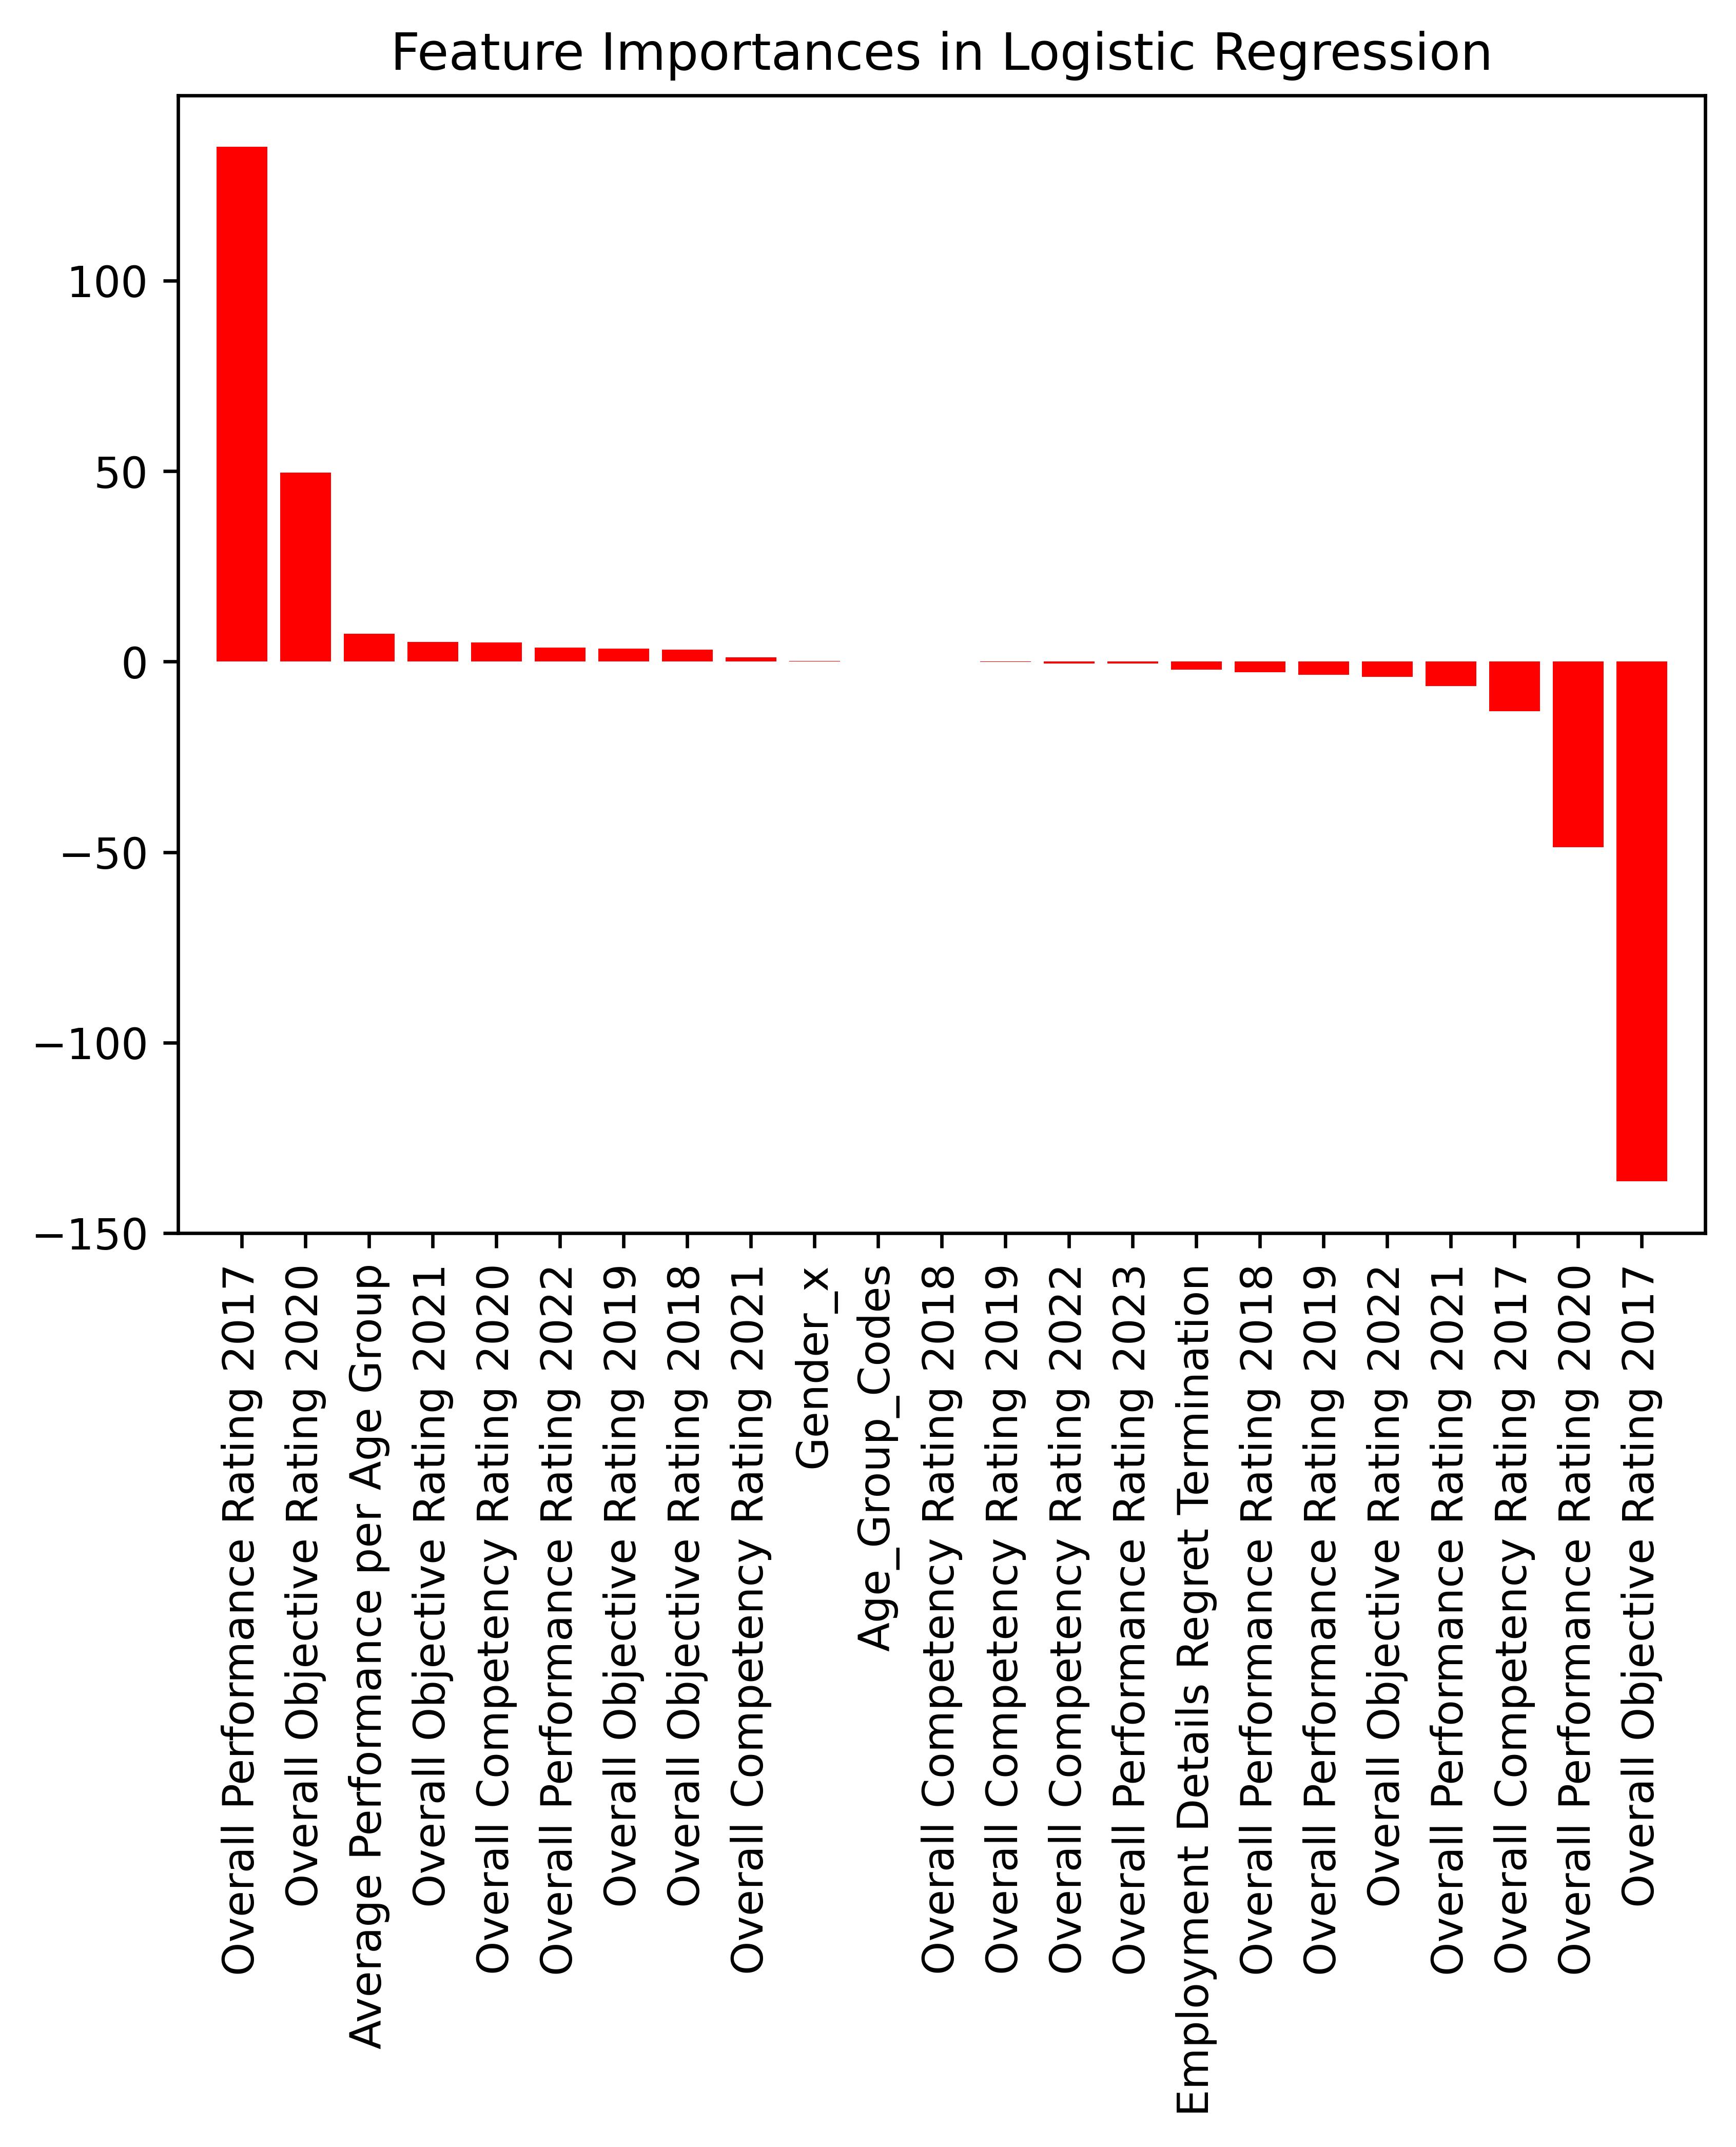

In [82]:
feature_importances_lr = best_lr_model.named_steps['classifier'].coef_[0]
indices = np.argsort(feature_importances_lr)[::-1]

plt.figure(dpi = 600)
plt.title("Feature Importances in Logistic Regression")
plt.bar(range(X_train.shape[1]), feature_importances_lr[indices],
       color="r", align="center")
plt.xticks(range(X_train.shape[1]), np.array(X_features)[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.show()

### SHAP Values

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


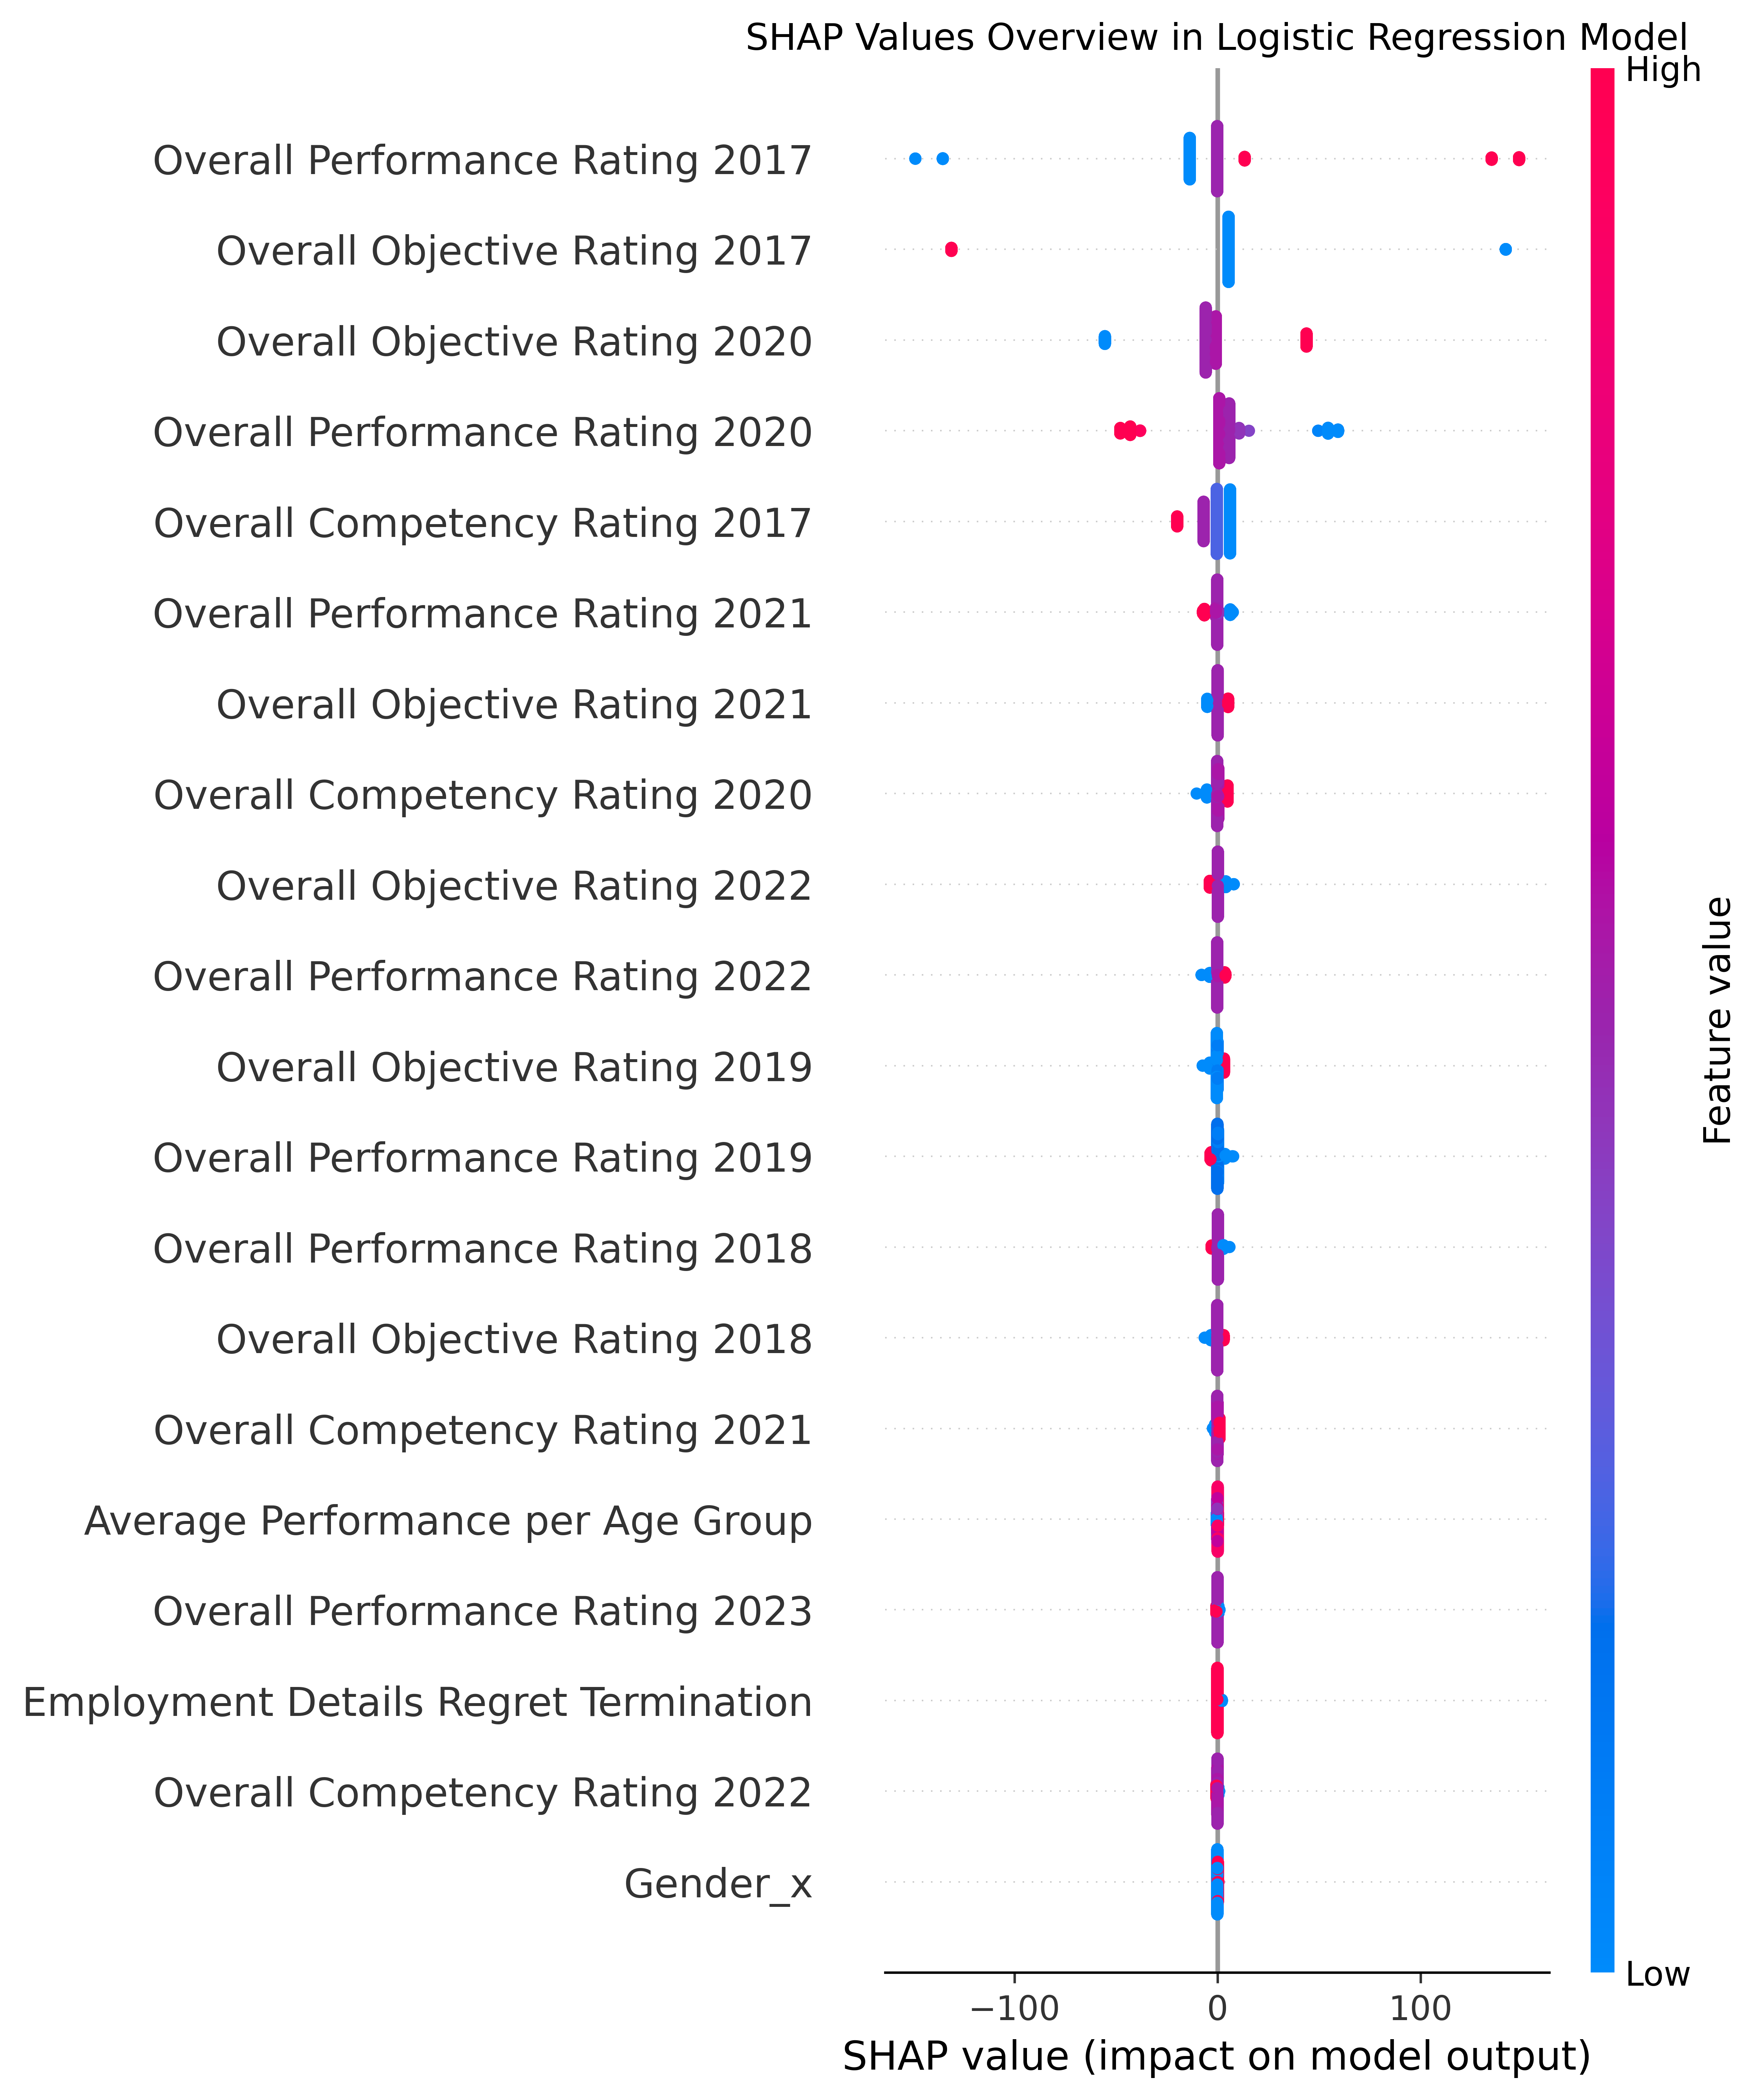

In [99]:
import shap
import matplotlib.pyplot as plt

# Initialize the SHAP explainer on the logistic regression classifier from your pipeline
explainer_lr = shap.LinearExplainer(best_lr_model.named_steps['classifier'], X_train)

# Calculate SHAP values for the test set
shap_values_lr = explainer_lr.shap_values(X_test)

# Create a summary plot using the SHAP values
plt.figure(dpi=600)
shap.summary_plot(shap_values_lr, X_test, feature_names=X_features, show=False)  
plt.title('SHAP Values Overview in Logistic Regression Model') 
plt.show()  

### Robustness Checks

#### Stratified cross-validation

In [16]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, accuracy_score, f1_score
import numpy as np
import pandas as pd

# Define the number of splits for cross-validation
n_splits = 10

# Define stratified k-fold cross-validator
skf_lr = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Define the pipeline using ImbPipeline to handle SMOTE properly
pipeline_lr = ImbPipeline([
    ('smote', SMOTE(random_state=42)),
    ('classifier', LogisticRegression(random_state=42))
])

# Parameters grid
param_grid_lr = {
    'classifier__C': [0.01, 0.1, 1, 10, 100],
    'classifier__penalty': ['l1', 'l2'],
    'classifier__solver': ['liblinear', 'saga']  # These solvers can handle L1 penalty
}

# Lists to store performance metrics and classification reports
accuracy_scores_skf = []
f1_scores_skf = []
f1_scores_train_skf = []
classification_reports_skf = []

# Perform cross-validation with stratification manually
for train_index, test_index in skf_lr.split(X, y):
    X_train_skf, X_test_skf = X.iloc[train_index], X.iloc[test_index]
    y_train_skf, y_test_skf = y.iloc[train_index], y.iloc[test_index]
    
    # Grid search inside the loop
    grid_search_lr_skf = GridSearchCV(pipeline_lr, param_grid_lr, cv=2, scoring='f1')  # using 2-fold CV for grid search to keep it light
    grid_search_lr_skf.fit(X_train_skf, y_train_skf)
    
    # Best estimator from grid search
    best_model_lr_skf = grid_search_lr_skf.best_estimator_
    
    # Predict on the training data using the best model for training F1 score
    y_train_pred_skf = best_model_lr_skf.predict(X_train_skf)
    
    # Calculate F1 score for the training data
    f1_train_lr_skf = f1_score(y_train_skf, y_train_pred_skf)
    f1_scores_train_skf.append(f1_train_lr_skf)

    # Predict on the validation data using the best model
    y_pred_skf = best_model_lr_skf.predict(X_test_skf)
    
    # Calculate and store performance metrics
    accuracy_scores_skf.append(accuracy_score(y_test_skf, y_pred_skf))
    f1_scores_skf.append(f1_score(y_test_skf, y_pred_skf))
    
    # Generate and store classification report
    report_skf = classification_report(y_test_skf, y_pred_skf, output_dict=True)
    classification_reports_skf.append(report_skf)

# Report the mean and standard deviation of the performance metrics
print("Accuracy: Mean =", np.mean(accuracy_scores_skf), "Std Dev =", np.std(accuracy_scores_skf))
print("F1 Score (Test): Mean =", np.mean(f1_scores_skf), "Std Dev =", np.std(f1_scores_skf))
print("F1 Score (Train): Mean =", np.mean(f1_scores_train_skf), "Std Dev =", np.std(f1_scores_train_skf))

# Display classification reports for each fold
for i, report in enumerate(classification_reports_skf, 1):
    print(f"\nClassification Report for Fold {i}:\n", pd.DataFrame(report).T)



The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
Liblinear failed to converge, increase the number of iterations.
Liblinear failed to converge, increase the number of iterations.
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
Liblinear failed to converge, increase the number of iterations.
Liblinear failed to converge, increase the number of iterations.
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means

Accuracy: Mean = 0.9740339017253558 Std Dev = 0.005376477672196931
F1 Score (Test): Mean = 0.9618735804933388 Std Dev = 0.0077154511518623126
F1 Score (Train): Mean = 0.9620148185195543 Std Dev = 0.001212333184032322

Classification Report for Fold 1:
               precision    recall  f1-score     support
0              0.993220  0.971808  0.982397  603.000000
1              0.945513  0.986622  0.965630  299.000000
accuracy       0.976718  0.976718  0.976718    0.976718
macro avg      0.969367  0.979215  0.974014  902.000000
weighted avg   0.977406  0.976718  0.976839  902.000000

Classification Report for Fold 2:
               precision    recall  f1-score     support
0              0.994907  0.971808  0.983221  603.000000
1              0.945687  0.989967  0.967320  299.000000
accuracy       0.977827  0.977827  0.977827    0.977827
macro avg      0.970297  0.980887  0.975271  902.000000
weighted avg   0.978591  0.977827  0.977950  902.000000

Classification Report for Fold 3:
    

In [17]:
# Calculate Kohen's Cappa - StratifiedKFold LR
from sklearn.metrics import cohen_kappa_score
kappa_skf = cohen_kappa_score(y_test_skf, y_pred_skf)
print("Cohen's Kappa Score:", kappa_skf)


Cohen's Kappa Score: 0.9429673072741934


#### Adding noise with resampling

In [18]:
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, f1_score, accuracy_score, cohen_kappa_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

# Function to add Gaussian noise
def add_gaussian_noise(X, noise_level=0.1, categorical_indices=None):
    noise = np.random.normal(0, noise_level, X.shape)
    if categorical_indices is not None:
        noise[:, categorical_indices] = 0  # Apply no noise to categorical column indices
    X_noisy = X + noise
    return X_noisy

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Add Gaussian noise to the test set
noise_level = 0.1  # Adjust the noise level as needed
X_test_noisy = add_gaussian_noise(X_test_scaled, noise_level=noise_level)

# Define pipeline with scaled data
pipeline_lr = ImbPipeline([
    ('smote', SMOTE(random_state=42)),
    ('classifier', LogisticRegression(random_state=42))
])

# Setup grid search
param_grid_lr = {
    'classifier__C': [0.01, 0.1, 1, 10, 100],
    'classifier__penalty': ['l1', 'l2'],
    'classifier__solver': ['liblinear', 'saga'] 
}
grid_search = GridSearchCV(pipeline_lr, param_grid_lr, cv=10, scoring='f1')
grid_search.fit(X_train_scaled, y_train)

# Best model
best_lr_model_noisy = grid_search.best_estimator_

# Evaluate the best model on the training data
y_train_pred = best_lr_model_noisy.predict(X_train_scaled)
print("F1 Score on Training Data:", f1_score(y_train, y_train_pred))

# Evaluate the best model on the noisy test data
y_pred_noisy = best_lr_model_noisy.predict(X_test_noisy)
print("F1 Score on Noisy Test Data:", f1_score(y_test, y_pred_noisy))
print("Accuracy Score on Noisy Test Data:", accuracy_score(y_test, y_pred_noisy))
print("\nClassification Report on Noisy Test Data:\n")
print(classification_report(y_test, y_pred_noisy))

# Calculate Cohen's Kappa
kappa_noisy = cohen_kappa_score(y_test, y_pred_noisy)
print("Cohen's Kappa Score on Noisy Test Data:", kappa_noisy)

The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the

F1 Score on Training Data: 0.9722743381279966
F1 Score on Noisy Test Data: 0.5127478753541077
Accuracy Score on Noisy Test Data: 0.6184137548530227

Classification Report on Noisy Test Data:

              precision    recall  f1-score   support

           0       0.74      0.64      0.69      1180
           1       0.46      0.58      0.51       623

    accuracy                           0.62      1803
   macro avg       0.60      0.61      0.60      1803
weighted avg       0.64      0.62      0.63      1803

Cohen's Kappa Score on Noisy Test Data: 0.2062259797202609


Liblinear failed to converge, increase the number of iterations.


<Figure size 1920x1440 with 0 Axes>

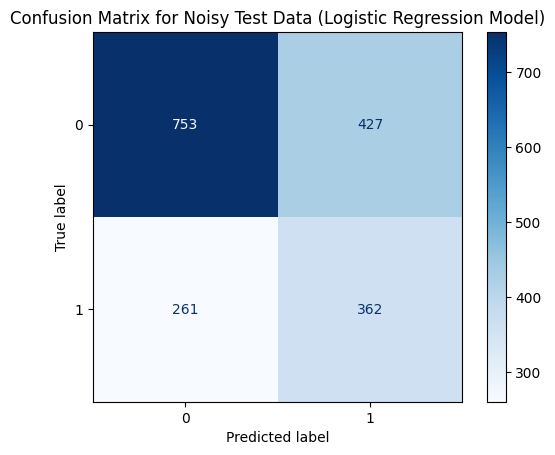

In [90]:
# Noisy dataset - confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Compute the confusion matrix
cm_lr_noisy = confusion_matrix(y_test, y_pred_noisy)
plt.figure(dpi=300)

# Visualize the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm_lr_noisy)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Noisy Test Data (Logistic Regression Model)')
plt.show()


## Random Forest

In [19]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, f1_score, accuracy_score
import numpy as np

# List of years and rating types
years_rf = ['2017', '2018', '2019', '2020', '2021', '2022', '2023']
rating_types_rf = ['Overall Competency Rating', 'Overall Objective Rating', 'Overall Performance Rating']

# Selecting features for each year
features_rf = []
for year in years_rf:
    for rating_type in rating_types_rf:
        col_name = f"{rating_type} {year}"
        if col_name in df_filtered.columns:
            features_rf.append(col_name)


# Additional features assumed to be in your DataFrame
additional_features_rf = ['Gender_x', 'Age_Group_Codes', 'Employment Details Regret Termination', 'Average Performance per Age']

# Combine all features
X_features_rf = features_rf + additional_features_rf

# Defining independent variables (features)
X_rf = df_filtered[X_features_rf]

# Defining the target variable
y_rf = df_filtered['Employee Status'].apply(lambda x: 1 if x == 'Terminated' else 0)

# Splitting the data into training and testing sets
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X_rf, y_rf, test_size=0.2, random_state=42)

# Define pipeline with Random Forest and SMOTE but without scaler
pipeline_rf = ImbPipeline([
    ('smote', SMOTE(random_state=42)),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Parameters grid for Random Forest
param_grid_rf = {
    'classifier__n_estimators': [100, 200, 300],  # Number of trees in the forest
    'classifier__max_depth': [None, 10, 20, 30],  # Maximum depth of the tree
    'classifier__min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'classifier__min_samples_leaf': [1, 2, 4]  # Minimum number of samples required to be at a leaf node
}

# Setup grid search
grid_search_rf = GridSearchCV(pipeline_rf, param_grid_rf, cv=10, scoring='f1')
grid_search_rf.fit(X_train_rf, y_train_rf)

# Best model
best_rf_model = grid_search_rf.best_estimator_

### Prediction on Train Data

In [20]:
# Predict on training data
train_pred_rf = best_rf_model.predict(X_train_rf)

# Evaluate accuracy and F1-score on training data
train_accuracy_rf = accuracy_score(y_train_rf, train_pred_rf)
train_f1_rf = f1_score(y_train_rf, train_pred_rf)

print("Training Data Accuracy:", train_accuracy_rf)
print("Training Data F1 Score:", train_f1_rf)

Training Data Accuracy: 0.9858510195588848
Training Data F1 Score: 0.9788644840447576


### Prediction on Test Data

In [21]:
# Predict on test data
y_pred_rf = best_rf_model.predict(X_test_rf)

# Evaluate accuracy and F1-score on test data
test_accuracy_rf = accuracy_score(y_test_rf, y_pred_rf)
test_f1_rf = f1_score(y_test_rf, y_pred_rf)

print("Test Data Accuracy:", test_accuracy_rf)
print("Test Data F1 Score:", test_f1_rf)
print(classification_report(y_test_rf, y_pred_rf))


Test Data Accuracy: 0.9833610648918469
Test Data F1 Score: 0.9763406940063092
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1180
           1       0.96      0.99      0.98       623

    accuracy                           0.98      1803
   macro avg       0.98      0.99      0.98      1803
weighted avg       0.98      0.98      0.98      1803



In [22]:
# Calculate Kohen's Cappa - baseline RF
from sklearn.metrics import cohen_kappa_score
kappa_rf = cohen_kappa_score(y_test_rf, y_pred_rf)
print("Cohen's Kappa Score:", kappa_rf)


Cohen's Kappa Score: 0.9635151706470139


### Missclassification Report

In [23]:
import pandas as pd

# Create a DataFrame with actual and predicted classes
results_df_rf = pd.DataFrame({'Actual': y_test_rf, 'Predicted': y_pred_rf})

# Add a column to flag misclassifications
results_df_rf['Misclassified'] = results_df_rf['Actual'] != results_df_rf['Predicted']

# Filter for misclassified instances
misclassified_df_rf = results_df_rf[results_df_rf['Misclassified'] == True]

# Optionally, merge this DataFrame with your original data to see all features of misclassified instances
misclassified_full_df_rf = pd.merge(misclassified_df_rf, df_filtered, left_index=True, right_index=True, how='left')

# Display some of the misclassified instances with their features
print(misclassified_full_df_rf.head())

      Actual  Predicted  Misclassified Employee Status  \
7303       0          1           True          Active   
6962       0          1           True          Active   
4507       0          1           True          Active   
169        0          1           True          Active   
5867       0          1           True          Active   

     Employment Details System hire/migration date  \
7303                                    2023-10-24   
6962                                    2017-11-17   
4507                                    2023-11-01   
169                                     2018-02-01   
5867                                    2018-06-11   

     Employment Details Original Start Date Local pay-roll id Salutation  \
7303                             2023-10-24               NaN        NaN   
6962                             2008-05-26            BK1112        Ms.   
4507                             2023-11-01               NaN        Ms.   
169                   

### Feature Importance Analysis 

In [81]:
import matplotlib.pyplot as plt
import numpy as np

# Extract feature importances from the model
feature_importances_rf = best_rf_model.named_steps['classifier'].feature_importances_
indices_rf = np.argsort(feature_importances_rf)[::-1]

# Increasing the figure size for better visualization
plt.figure(figsize=(24, 16), dpi=600)  # Larger figure size
plt.title('Feature Importances in Random Forest', fontsize=24)  # Larger font size for the title
plt.bar(range(X_train_rf.shape[1]), feature_importances_rf[indices_rf],
        color='b', align='center')
plt.xticks(range(X_train_rf.shape[1]), [X_features_rf[i] for i in indices_rf], rotation=90, fontsize=14)  # Larger font size for x-axis tick labels
plt.xlim([-1, X_train_rf.shape[1]])
plt.xlabel('Features', fontsize=20)  
plt.ylabel('Importance', fontsize=20)  # Larger font size for y-axis label
plt.show()


### Error Analysis

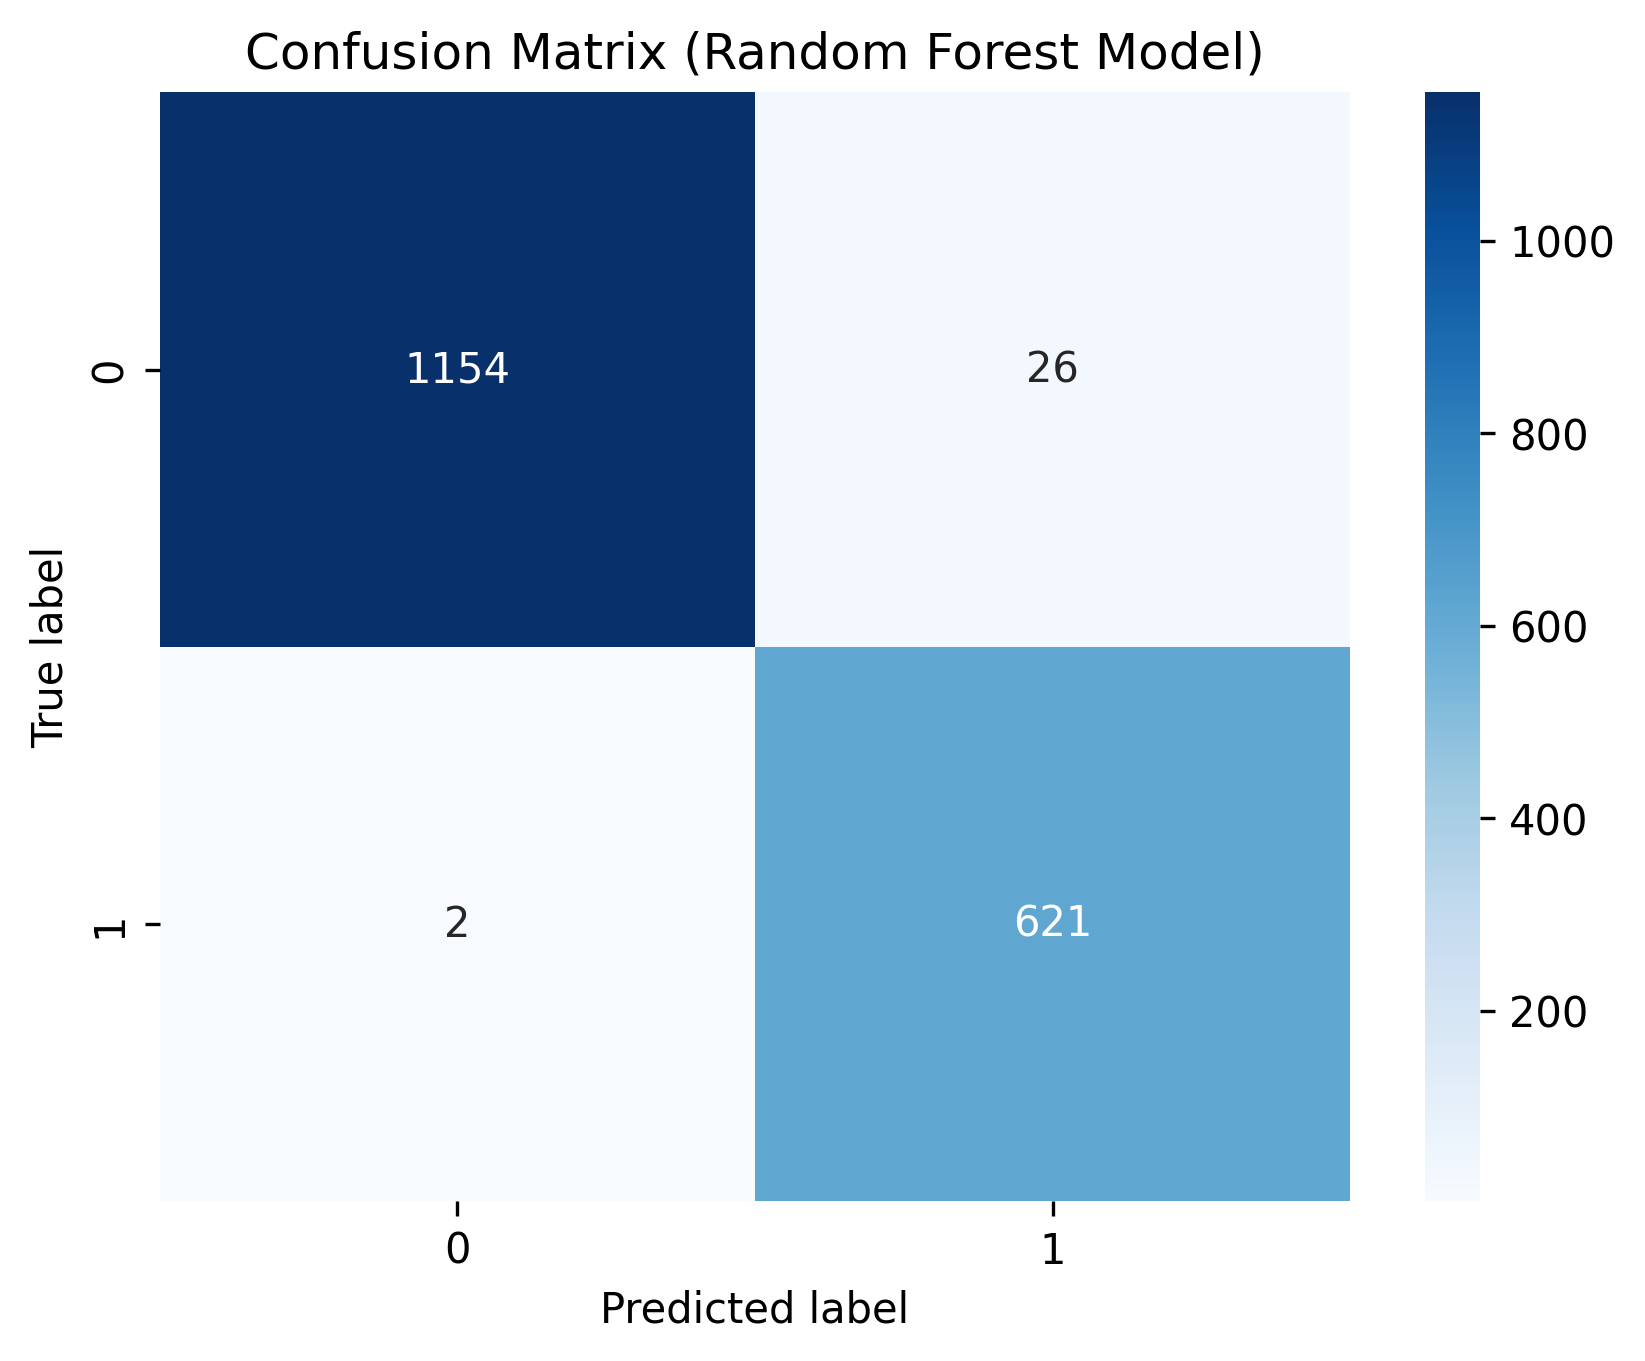

Sample Misclassified Indices: [  3 110 132 141 288 340 350 365 461 507]


In [89]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Generating the confusion matrix
cm_rf = confusion_matrix(y_test_rf, y_pred_rf)
plt.figure(dpi=300)
sns.heatmap(cm_rf, annot=True, fmt="d", cmap='Blues')
plt.title('Confusion Matrix (Random Forest Model)')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

# Investigate specific misclassified examples
misclassified_indices_rf = np.where(y_test_rf != y_pred_rf)[0]
print("Sample Misclassified Indices:", misclassified_indices_rf[:10])

### SHAP Values

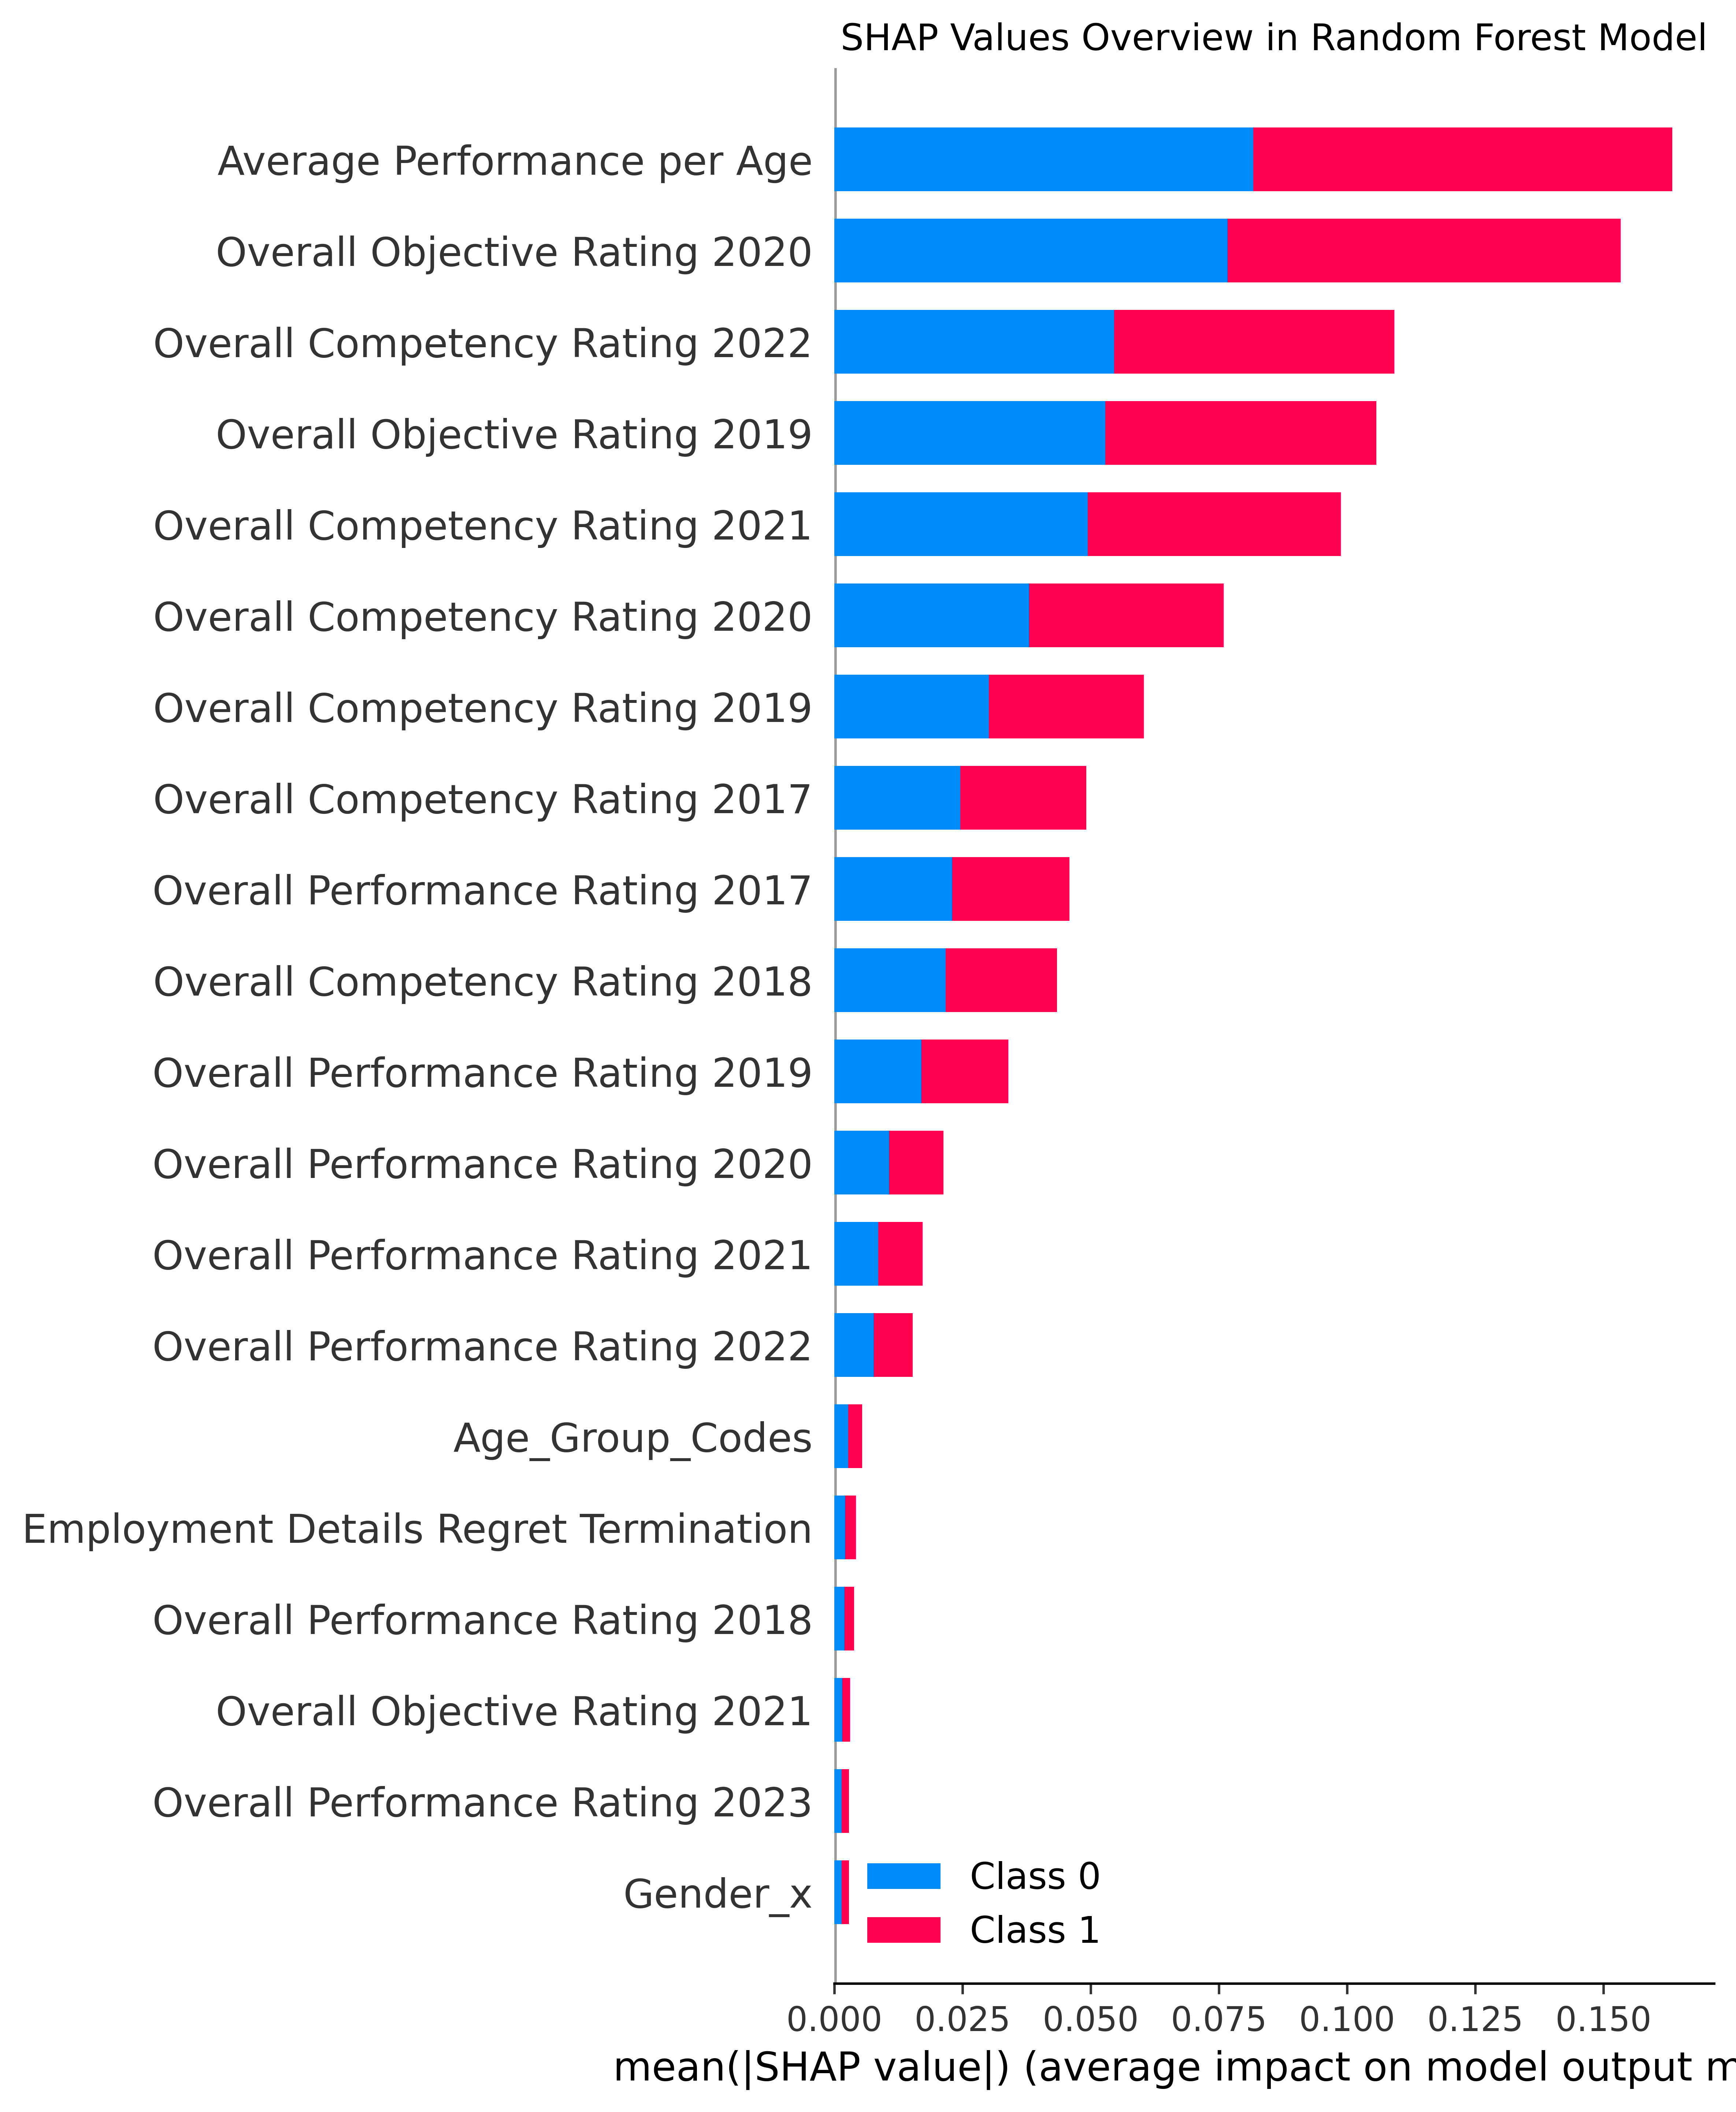

In [98]:
import shap
import matplotlib.pyplot as plt

# Initialize the SHAP explainer on the random forest classifier from your pipeline
explainer_rf = shap.TreeExplainer(best_rf_model.named_steps['classifier'])

# Calculate SHAP values - This could take some time depending on your dataset size
shap_values_rf = explainer_rf.shap_values(X_test_rf)

# Create a summary plot using the SHAP values
plt.figure(figsize=(24, 20), dpi=600)  
shap.summary_plot(shap_values_rf, X_test_rf, show=False) 
plt.title('SHAP Values Overview in Random Forest Model')  
plt.show()

### Robustness checks

#### Noise with resampling

In [27]:
from sklearn.utils import resample
import numpy as np
from sklearn.metrics import classification_report, f1_score, cohen_kappa_score
import pandas as pd

# Function to add Gaussian noise
def add_noise(data, noise_level=0.1):
    noise = np.random.randn(*data.shape) * noise_level
    return data + noise

# Number of bootstrap samples
bootstrap_samples = 100
f1_scores = []
f1_scores_train = []  # List to store F1 scores for training data
classification_reports = []
kappa_scores = []  # List to store kappa scores

for _ in range(bootstrap_samples):
    # Resampling with replacement
    X_resampled, y_resampled = resample(X_train_rf, y_train_rf)
    
    # Add Gaussian noise to the resampled data
    X_resampled_noisy = add_noise(X_resampled)

    # Fit the RandomForest model on the noisy resampled data
    best_rf_model.fit(X_resampled_noisy, y_resampled)

    # Predict on the resampled, noisy training data to evaluate training performance
    y_train_pred = best_rf_model.predict(X_resampled_noisy)
    f1_train_score = f1_score(y_resampled, y_train_pred)
    f1_scores_train.append(f1_train_score)

    # Predict on the original, clean test set
    y_pred_rf = best_rf_model.predict(X_test_rf)
    
    # Calculate the F1 score and store it
    score = f1_score(y_test_rf, y_pred_rf)
    f1_scores.append(score)
    
    # Generate and store the classification report
    report = classification_report(y_test_rf, y_pred_rf, output_dict=True)
    classification_reports.append(report)

    # Calculate and store Cohen's Kappa score
    kappa = cohen_kappa_score(y_test_rf, y_pred_rf)
    kappa_scores.append(kappa)

# Calculate and print the average F1 score across all bootstrap samples
average_f1_score = np.mean(f1_scores)
print("Average F1 Score on noisy resampled data:", average_f1_score)
print("Average F1 Score on Training Data (noisy resampled):", np.mean(f1_scores_train))

# Calculate and print the average Cohen's Kappa score
average_kappa_score = np.mean(kappa_scores)
print("Average Cohen's Kappa Score on noisy resampled data:", average_kappa_score)

# Calculate the average classification report
def average_classification_report(reports):
    # Create a DataFrame to store all reports
    df_reports = pd.DataFrame(reports)
    
    # Initialize dictionary to hold average report
    avg_report = {}
    
    # Calculate mean for each column in DataFrame
    for column in df_reports.columns:
        avg_report[column] = df_reports[column].apply(pd.Series).mean().to_dict()
    
    return avg_report

average_report = average_classification_report(classification_reports)

# Print the average classification report
print("\nAverage Classification Report on Noisy Resampled Data:\n")
print(pd.DataFrame(average_report).transpose())

Average F1 Score on noisy resampled data: 0.9729476247718202
Average F1 Score on Training Data (noisy resampled): 0.9999747564028432
Average Cohen's Kappa Score on noisy resampled data: 0.9582842902284703

Average Classification Report on Noisy Resampled Data:

              precision    recall  f1-score  support         0
0              0.994656  0.976178  0.985330   1180.0       NaN
1              0.956414  0.990064  0.972948    623.0       NaN
accuracy            NaN       NaN       NaN      NaN  0.980976
macro avg      0.975535  0.983121  0.979139   1803.0       NaN
weighted avg   0.981442  0.980976  0.981051   1803.0       NaN


Returning a DataFrame from Series.apply when the supplied function returns a Series is deprecated and will be removed in a future version.


In [28]:
import pandas as pd

# Create a DataFrame with actual and predicted classes
results_df_rf = pd.DataFrame({'Actual': y_test_rf, 'Predicted': y_pred_rf})

# Add a column to flag misclassifications
results_df_rf['Misclassified'] = results_df_rf['Actual'] != results_df_rf['Predicted']

# Filter for misclassified instances
misclassified_df_rf = results_df_rf[results_df_rf['Misclassified'] == True]

# Optionally, merge this DataFrame with your original data to see all features of misclassified instances
misclassified_full_df_rf = pd.merge(misclassified_df_rf, df_filtered, left_index=True, right_index=True, how='left')

# Display some of the misclassified instances with their features
print(misclassified_full_df_rf.head())

      Actual  Predicted  Misclassified Employee Status  \
7303       0          1           True          Active   
2098       0          1           True          Active   
6962       0          1           True          Active   
4507       0          1           True          Active   
169        0          1           True          Active   

     Employment Details System hire/migration date  \
7303                                    2023-10-24   
2098                                    2017-10-25   
6962                                    2017-11-17   
4507                                    2023-11-01   
169                                     2018-02-01   

     Employment Details Original Start Date Local pay-roll id Salutation  \
7303                             2023-10-24               NaN        NaN   
2098                             2014-04-02             30847        NaN   
6962                             2008-05-26            BK1112        Ms.   
4507                  

#### Stratified cross-validation

In [29]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, f1_score, cohen_kappa_score
import numpy as np
import pandas as pd

# Initialize StratifiedKFold
str_kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
f1_scores_str = []
f1_scores_train_str = []  # List to store F1 scores for training data in each fold
classification_reports_str = []
kappa_scores_str = []  # List to store kappa scores for each fold

# Loop through each fold
for train_idx, test_idx in str_kfold.split(X_rf, y_rf):
    X_train_str, X_test_str = X_rf.iloc[train_idx], X_rf.iloc[test_idx]
    y_train_str, y_test_str = y_rf.iloc[train_idx], y_rf.iloc[test_idx]

    # Assuming best_rf_model is your pre-tuned RandomForest model
    best_rf_model.fit(X_train_str, y_train_str)

    # Predict on training data to evaluate training performance
    y_train_pred = best_rf_model.predict(X_train_str)
    f1_train_score = f1_score(y_train_str, y_train_pred)
    f1_scores_train_str.append(f1_train_score)

    # Predict on test data
    y_pred_str = best_rf_model.predict(X_test_str)
    
    # Calculate the F1 score for the current fold and append to the list
    f1_scores_str.append(f1_score(y_test_str, y_pred_str))
    
    # Generate and store the classification report for the current fold
    report_str = classification_report(y_test_str, y_pred_str, output_dict=True)
    classification_reports_str.append(report_str)
    
    # Calculate and store Cohen's Kappa for the current fold
    kappa_score = cohen_kappa_score(y_test_str, y_pred_str)
    kappa_scores_str.append(kappa_score)

# Print the F1 scores across all stratified folds
print("F1 Scores across stratified folds:", f1_scores_str)
print("F1 Scores on Training Data across stratified folds:", f1_scores_train_str)

# Calculate and print the average Cohen's Kappa score across all folds
average_kappa_score = np.mean(kappa_scores_str)
print("Average Cohen's Kappa Score across stratified folds:", average_kappa_score)

# Calculate the average classification report
def average_classification_report(reports):
    avg_report = {}
    for key in reports[0].keys():
        if isinstance(reports[0][key], dict):  # Check if the key holds a dictionary
            avg_report[key] = {
                metric: np.mean([report[key][metric] for report in reports])
                for metric in reports[0][key]
            }
        else:  # Handle float values like 'accuracy'
            avg_report[key] = np.mean([report[key] for report in reports])
    return avg_report

average_report_str = average_classification_report(classification_reports_str)

# Print the average classification report
print("\nAverage Classification Report on Stratified Cross-Validation Data:\n")
print(pd.DataFrame(average_report_str).transpose())


F1 Scores across stratified folds: [0.9834983498349834, 0.9770491803278689, 0.9706840390879479, 0.9739413680781759, 0.9819376026272578, 0.9785831960461284, 0.9737704918032786, 0.9867549668874172, 0.9672131147540983, 0.9768976897689768]
F1 Scores on Training Data across stratified folds: [0.9779559118236473, 0.978669097538742, 0.9793833242109105, 0.9792122538293218, 0.9783123747038455, 0.9785063752276867, 0.979219832300401, 0.9777858703568827, 0.9795769511305616, 0.9784985422740525]
Average Cohen's Kappa Score across stratified folds: 0.965303304305993

Average Classification Report on Stratified Cross-Validation Data:

              precision    recall  f1-score     support
0              0.998307  0.978429  0.988262  602.700000
1              0.958213  0.996648  0.977033  298.500000
accuracy       0.984465  0.984465  0.984465    0.984465
macro avg      0.978260  0.987538  0.982648  901.200000
weighted avg   0.985026  0.984465  0.984543  901.200000


### Misclassication rate on age groups

   Age_Group_Codes  Total Count  Misclassified Count  Misclassification Rate
0                0        112.0                  5.0                0.044643
1                1        491.0                 14.0                0.028513
2                2        669.0                  6.0                0.008969
3                3        407.0                  2.0                0.004914
4                4        124.0                  1.0                0.008065


<Figure size 1920x1440 with 0 Axes>

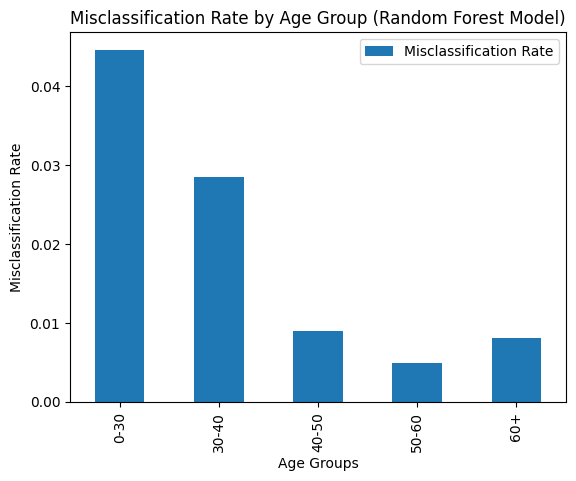

In [93]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

# Make predictions using the best model
y_pred_rf = best_rf_model.predict(X_test_rf[X_train_rf.columns])

# Add predictions and actual values to the test data
X_test_rf['Predicted Status'] = y_pred_rf
X_test_rf['Actual Status'] = y_test_rf

# Group by Age_Group_Codes to find misclassification patterns
age_group_analysis_rf = X_test_rf.groupby('Age_Group_Codes').apply(
    lambda x: pd.Series({
        'Total Count': len(x),
        'Misclassified Count': sum(x['Predicted Status'] != x['Actual Status']),
        'Misclassification Rate': sum(x['Predicted Status'] != x['Actual Status']) / len(x)
    })
).reset_index()

# Print the age group analysis results
print(age_group_analysis_rf)

# Plotting the data with customizations
plt.figure(dpi=300)
age_group_analysis_rf.plot(x='Age_Group_Codes', y='Misclassification Rate', kind='bar', title='Misclassification Rate by Age Group (Random Forest Model)')
plt.xlabel('Age Groups')  
plt.ylabel('Misclassification Rate')  
plt.xticks(ticks=age_group_analysis_rf.index, labels=['0-30', '30-40', '40-50', '50-60', '60+'])  
plt.show()


## CatBoost Model

In [30]:
from sklearn.model_selection import train_test_split, GridSearchCV
from catboost import CatBoostClassifier
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, f1_score, accuracy_score

# List of years and rating types
years_cb = ['2017', '2018', '2019', '2020', '2021', '2022', '2023']
rating_types_cb = ['Overall Competency Rating', 'Overall Objective Rating', 'Overall Performance Rating']

# Selecting features for each year
features_cb = []
for year in years_cb:
    for rating_type in rating_types_cb:
        col_name = f"{rating_type} {year}"
        if col_name in df_filtered.columns:
            features_cb.append(col_name)

# Additional features assumed to be in your DataFrame
additional_features_cb = ['Gender_x', 'Age_Group_Codes', 'Employment Details Regret Termination', 'Average Performance per Age']

# Combine all features
X_features_cb = features_cb + additional_features_cb

# Defining independent variables (features)
X_cb = df_filtered[X_features_cb]

# Defining the target variable
y_cb = df_filtered['Employee Status'].apply(lambda x: 1 if x == 'Terminated' else 0)

# Splitting the data into training and testing sets
X_train_cb, X_test_cb, y_train_cb, y_test_cb = train_test_split(X_cb, y_cb, test_size=0.2, random_state=42)

# Define pipeline
pipeline_cb = ImbPipeline([
    ('smote', SMOTE(random_state=42)),
    ('classifier', CatBoostClassifier(random_state=42, verbose=0))
])

# Parameters grid for CatBoost
param_grid_cb = {
    'classifier__depth': [6, 8, 10],
    'classifier__learning_rate': [0.01, 0.1, 0.5],
    'classifier__iterations': [100, 500, 1000]
}

# Setup grid search with 10-fold cross-validation
grid_search_cb = GridSearchCV(pipeline_cb, param_grid_cb, cv=10, scoring='f1', verbose=1)
grid_search_cb.fit(X_train_cb, y_train_cb)

# Best model
best_catboost_model = grid_search_cb.best_estimator_

Fitting 10 folds for each of 27 candidates, totalling 270 fits


### Predict on Train Data

In [31]:
# Predict on training data
train_pred_cb = best_catboost_model.predict(X_train_cb)

# Evaluate accuracy and F1-score on training data
train_accuracy_cb = accuracy_score(y_train_cb, train_pred_cb)
train_f1_cb = f1_score(y_train_cb, train_pred_cb)

print("Training Data Accuracy:", train_accuracy_cb)
print("Training Data F1 Score:", train_f1_cb)

Training Data Accuracy: 0.9852961575808018
Training Data F1 Score: 0.978017420157611


### Predict on Test Data

In [32]:
# Predicting the test data
test_pred_cb = best_catboost_model.predict(X_test_cb)
test_f1_cb = f1_score(y_test_cb, test_pred_cb)
test_accuracy_cb = accuracy_score(y_test_cb, test_pred_cb)

print(classification_report(y_test_cb, test_pred_cb))
print(f"Accuracy: {test_accuracy_cb}")
print(f"F1 Score: {test_f1_cb}")

              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1180
           1       0.96      0.99      0.98       623

    accuracy                           0.98      1803
   macro avg       0.98      0.99      0.98      1803
weighted avg       0.98      0.98      0.98      1803

Accuracy: 0.9833610648918469
F1 Score: 0.9763406940063092


In [33]:
# Calculate Kohen's Cappa
from sklearn.metrics import cohen_kappa_score
kappa_cb = cohen_kappa_score(y_test_cb, test_pred_cb)
print("Cohen's Kappa Score:", kappa_cb)

Cohen's Kappa Score: 0.9635151706470139


### Misclassification Report

In [34]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

# Predicting with the best model from the grid search
test_pred_cb = best_catboost_model.predict(X_test_cb)

# Classification report
cr_cb = classification_report(y_test_cb, test_pred_cb)
print("Classification Report:")
print(cr_cb)

# Identify indices of misclassified examples
misclassified_indices_cb = np.where(y_test_cb != test_pred_cb)[0]
print(f"Total misclassified samples: {len(misclassified_indices_cb)}")

# Create a DataFrame for analyzing misclassified examples
misclassified_df_cb = X_test_cb.iloc[misclassified_indices_cb]
misclassified_df_cb['Actual'] = y_test_cb.iloc[misclassified_indices_cb]
misclassified_df_cb['Predicted'] = test_pred_cb[misclassified_indices_cb]

# Display a sample of misclassified examples for analysis
print("Sample Misclassified Examples:")
print(misclassified_df_cb.sample(10))

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1180
           1       0.96      0.99      0.98       623

    accuracy                           0.98      1803
   macro avg       0.98      0.99      0.98      1803
weighted avg       0.98      0.98      0.98      1803

Total misclassified samples: 30
Sample Misclassified Examples:
      Overall Competency Rating 2017  Overall Objective Rating 2017  \
7080                             2.5                              3   
4838                             2.5                              3   
6927                             2.5                              3   
7173                             2.0                              3   
8477                             2.5                              3   
8334                             2.5                              3   
5623                             2.5                              3   
3946               


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


#### Misclassification rate per age group

<Figure size 1920x1440 with 0 Axes>

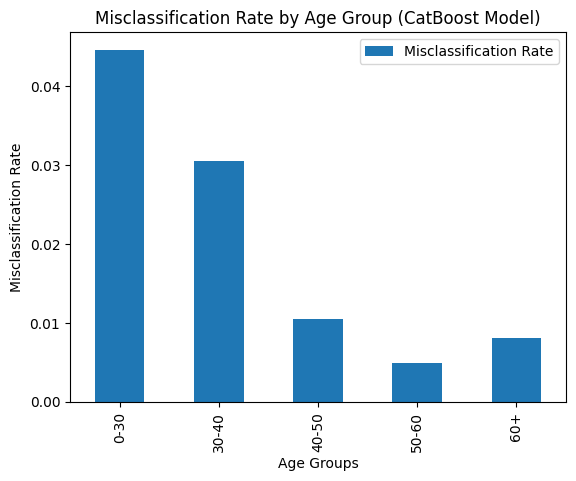

In [75]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

# Make predictions using the best model
y_pred_cb = best_catboost_model.predict(X_test_cb)

# Add predictions and actual values to the test data
X_test_cb['Predicted Status'] = y_pred_cb
X_test_cb['Actual Status'] = y_test_cb

# Group by Age_Group_Codes to find misclassification patterns
age_group_analysis = X_test_cb.groupby('Age_Group_Codes').apply(
    lambda x: pd.Series({
        'Total Count': len(x),
        'Misclassified Count': sum(x['Predicted Status'] != x['Actual Status']),
        'Misclassification Rate': sum(x['Predicted Status'] != x['Actual Status']) / len(x)
    })
).reset_index()

# Plotting the data with customizations
plt.figure(dpi=300)
age_group_analysis.plot(x='Age_Group_Codes', y='Misclassification Rate', kind='bar', title='Misclassification Rate by Age Group (CatBoost Model)')
plt.xlabel('Age Groups') 
plt.ylabel('Misclassification Rate')  
plt.xticks(ticks=age_group_analysis.index, labels=['0-30', '30-40', '40-50', '50-60', '60+']) 
plt.show()

### Feature Importance Analysis

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from catboost import CatBoostClassifier

if isinstance(best_catboost_model.named_steps['classifier'], CatBoostClassifier):
    # Extracting feature importances
    feature_importances_cb = best_catboost_model.named_steps['classifier'].get_feature_importance()

    # Creating a DataFrame to hold feature names and their importance scores
    features_df_cb = pd.DataFrame({
        'Feature': X_features_cb,  # Make sure this matches the features used for training
        'Importance': feature_importances_cb
    })

    # Sorting the DataFrame by importance score
    features_df_cb = features_df_cb.sort_values(by='Importance', ascending=False)

    # Plotting feature importances
    plt.figure(figsize=(30, 25), dpi=600)
    sns.barplot(data=features_df_cb, x='Importance', y='Feature')
    plt.title('Feature Importances in CatBoost Model', fontsize=22) 
    plt.xlabel('Importance Score', fontsize=22)  
    plt.ylabel('Features', fontsize=20)  
    plt.xticks(fontsize=20)  
    plt.yticks(fontsize=20)  
    plt.show()

else:
    print("The pipeline's classifier is not a CatBoostClassifier or has been modified.")


### Error Analysis (CatBoost)

<Figure size 1920x1440 with 0 Axes>

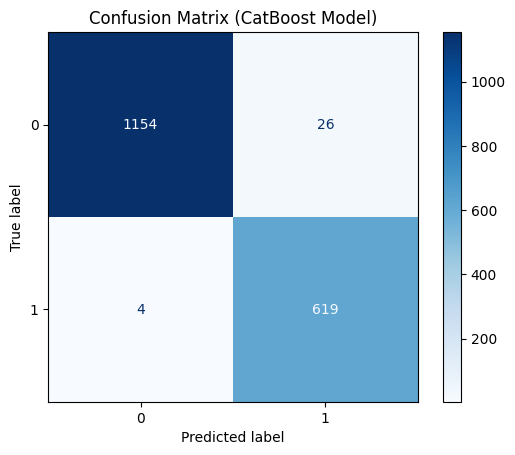

In [88]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Generate predictions
y_pred_cb = best_catboost_model.predict(X_test_cb)

# Create confusion matrix
cm_cb = confusion_matrix(y_test_cb, y_pred_cb)
plt.figure(dpi=300)
disp_cb = ConfusionMatrixDisplay(confusion_matrix=cm_cb)

# Plot confusion matrix
disp_cb.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix (CatBoost Model)')
plt.show()

### SHAP Values (CatBoost)

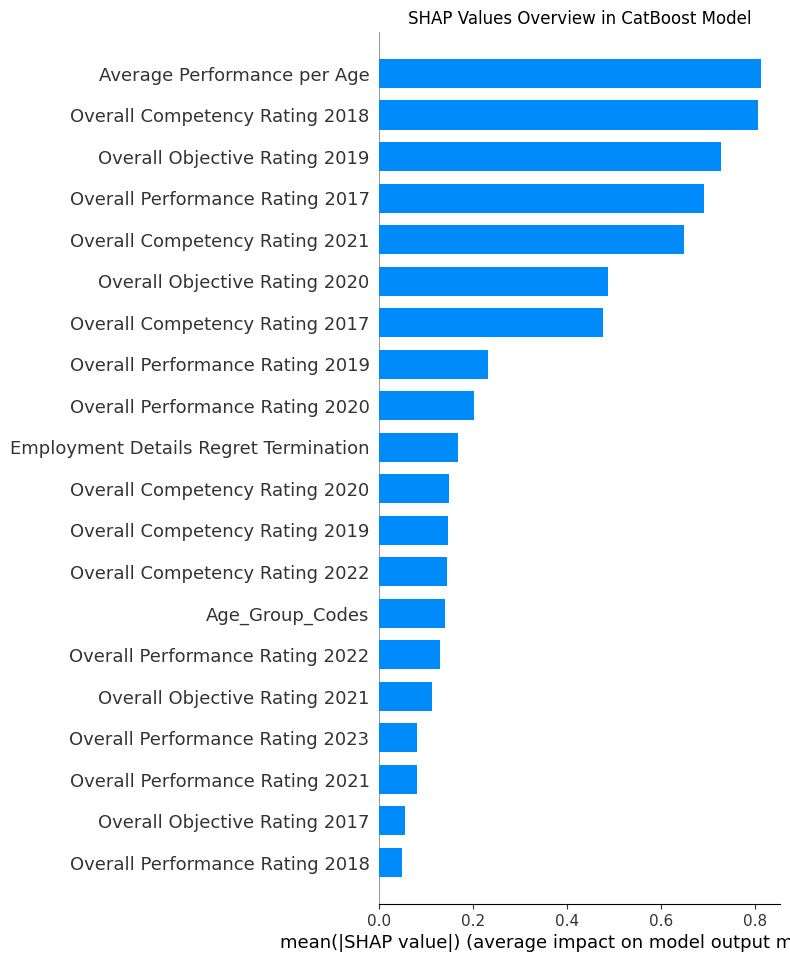

In [94]:
import shap
from catboost import Pool

# Initialize the JS visualization code in the notebook 
shap.initjs()

# Create object that can calculate shap values
explainer_cb = shap.TreeExplainer(best_catboost_model.named_steps['classifier'])

# Calculate SHAP values for the test set
shap_values_cb = explainer_cb.shap_values(Pool(X_test_cb, label=y_test_cb))

# Plot summary of SHAP values for all features across all samples
plt.figure()
shap.summary_plot(shap_values_cb, X_test_cb, feature_names=X_features_cb, plot_type='bar', show=False)
plt.title('SHAP Values Overview in CatBoost Model')  

# Plot SHAP values for a single prediction to understand the model's decision making
sample_idx_cb = 1  
shap.force_plot(explainer_cb.expected_value, shap_values_cb[sample_idx_cb,:], X_test_cb.iloc[sample_idx_cb,:], feature_names=X_features_cb)


### Robustness Checks 

#### Noise with resampling

In [39]:
from sklearn.utils import resample
import numpy as np
from sklearn.metrics import classification_report, f1_score, cohen_kappa_score
import pandas as pd

# Function to add Gaussian noise
def add_noise(data, noise_level=0.1):
    noise = np.random.randn(*data.shape) * noise_level
    return data + noise

# Number of bootstrap samples
bootstrap_samples = 100
f1_scores = []
f1_scores_train = []  # List to store F1 scores for training data in each bootstrap sample
classification_reports = []
kappa_scores = []  # To store Cohen's Kappa scores

for _ in range(bootstrap_samples):
    # Resampling with replacement
    X_resampled, y_resampled = resample(X_train_cb, y_train_cb)
    
    # Add Gaussian noise to the resampled data
    X_resampled_noisy = add_noise(X_resampled)

    # Fit the CatBoost model on the noisy resampled data
    # Ensure 'verbose' is turned off in the model configuration within the pipeline
    best_catboost_model['classifier'].fit(X_resampled_noisy, y_resampled)

    # Predict on the noisy resampled training data to evaluate training performance
    y_train_pred = best_catboost_model.predict(X_resampled_noisy)
    f1_train_score = f1_score(y_resampled, y_train_pred)
    f1_scores_train.append(f1_train_score)

    # Predict on the original, clean test set
    y_pred = best_catboost_model.predict(X_test_cb)
    
    # Calculate the F1 score and store it
    score = f1_score(y_test_cb, y_pred)
    f1_scores.append(score)
    
    # Generate and store the classification report
    report = classification_report(y_test_cb, y_pred, output_dict=True)
    classification_reports.append(report)

    # Calculate and store Cohen's Kappa
    kappa = cohen_kappa_score(y_test_cb, y_pred)
    kappa_scores.append(kappa)

# Calculate and print the average F1 score across all bootstrap samples
average_f1_score = np.mean(f1_scores)
print("Average F1 Score on noisy resampled data:", average_f1_score)
print("Average F1 Score on Training Data (noisy resampled):", np.mean(f1_scores_train))

# Calculate and print the average Cohen's Kappa score
average_kappa_score = np.mean(kappa_scores)
print("Average Cohen's Kappa Score on noisy resampled data:", average_kappa_score)

# Combine all classification reports into a single DataFrame for averaging
df_reports = pd.DataFrame(classification_reports)

# Aggregate classification reports by averaging each metric
average_report = df_reports.apply(lambda col: pd.DataFrame(col.tolist()).mean()).to_dict()

# Print the average classification report
print("\nAverage Classification Report on Noisy Resampled Data:\n")
print(pd.DataFrame(average_report).transpose())

Average F1 Score on noisy resampled data: 0.9716605663753041
Average F1 Score on Training Data (noisy resampled): 0.9750297599267386
Average Cohen's Kappa Score on noisy resampled data: 0.9562562923436334

Average Classification Report on Noisy Resampled Data:

                     0  f1-score  precision    recall  support
0                  NaN  0.984587   0.994896  0.974492   1180.0
1                  NaN  0.971661   0.953504  0.990530    623.0
accuracy      0.980033       NaN        NaN       NaN      NaN
macro avg          NaN  0.978124   0.974200  0.982511   1803.0
weighted avg       NaN  0.980120   0.980594  0.980033   1803.0


#### Stratified cross-validation

In [41]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, f1_score, cohen_kappa_score
import numpy as np
import pandas as pd

# Initialize StratifiedKFold
str_kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
f1_scores = []
f1_scores_train = []  # List to store F1 scores for training data in each fold
classification_reports = []
kappa_scores = []  # List to store Cohen's Kappa scores for each fold

# Perform cross-validation with stratification
for train_idx, test_idx in str_kfold.split(X_cb, y_cb):
    X_train_str, X_test_str = X_cb.iloc[train_idx], X_cb.iloc[test_idx]
    y_train_str, y_test_str = y_cb.iloc[train_idx], y_cb.iloc[test_idx]
    
    # Fit the best model from GridSearch on the stratified training data
    best_catboost_model.fit(X_train_str, y_train_str)

    # Predict on the training data to evaluate training performance
    y_train_pred = best_catboost_model.predict(X_train_str)
    f1_train_score = f1_score(y_train_str, y_train_pred)
    f1_scores_train.append(f1_train_score)

    # Predict on the stratified test set
    y_pred_str = best_catboost_model.predict(X_test_str)
    
    # Calculate the F1 score for the current fold and append to the list
    f1_scores.append(f1_score(y_test_str, y_pred_str))
    
    # Generate and store the classification report for the current fold
    report_str = classification_report(y_test_str, y_pred_str, output_dict=True)
    classification_reports.append(report_str)

    # Calculate and store Cohen's Kappa for the current fold
    kappa = cohen_kappa_score(y_test_str, y_pred_str)
    kappa_scores.append(kappa)

# Print the average F1 score across all stratified folds
average_f1_score = np.mean(f1_scores)
print("Average F1 Score across stratified folds:", average_f1_score)
print("Average F1 Score on Training Data across stratified folds:", np.mean(f1_scores_train))

# Print the average Cohen's Kappa score across all folds
average_kappa_score = np.mean(kappa_scores)
print("Average Cohen's Kappa Score across stratified folds:", average_kappa_score)

# Calculate the average classification report
def average_classification_report(reports):
    # Convert list of dicts into DataFrame for each 'macro avg' key
    report_df = pd.DataFrame.from_records([report['macro avg'] for report in reports])
    # Calculate mean for each column
    return report_df.mean()

# Calculate and display the average classification report
avg_report = average_classification_report(classification_reports)
print("\nAverage Classification Report on Stratified Cross-Validation Data:\n", avg_report)

Average F1 Score across stratified folds: 0.977353363433916
Average F1 Score on Training Data across stratified folds: 0.9776312586783937
Average Cohen's Kappa Score across stratified folds: 0.9657930571586674

Average Classification Report on Stratified Cross-Validation Data:
 precision      0.978567
recall         0.987704
f1-score       0.982893
support      901.200000
dtype: float64


## XGBoost Model

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBClassifier
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, f1_score, accuracy_score

# List of years and rating types
years_xgb = ['2017', '2018', '2019', '2020', '2021', '2022', '2023']
rating_types_xgb = ['Overall Competency Rating', 'Overall Objective Rating', 'Overall Performance Rating']

# Selecting features for each year
features_xgb = []
for year in years:
    for rating_type in rating_types:
        col_name = f"{rating_type} {year}"
        if col_name in df_filtered.columns:
            features.append(col_name)

# Additional features assumed to be in your DataFrame
additional_features_xgb = ['Gender_x', 'Age_Group_Codes', 'Employment Details Regret Termination', 'Average Performance per Age']

# Combine all features
X_features_xgb = features_xgb + additional_features_xgb

# Defining independent variables (features)
X_xgb = df_filtered[X_features_xgb]

# Defining the target variable
y_xgb = df_filtered['Employee Status'].apply(lambda x: 1 if x == 'Terminated' else 0)

# Splitting the data into training and testing sets
X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb = train_test_split(X_xgb, y_xgb, test_size=0.2, random_state=42)

# Define pipeline
pipeline_xgb = ImbPipeline([
    ('smote', SMOTE(random_state=42)),
    ('classifier', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))
])

# Parameters grid for XGBoost
param_grid_xgb = {
    'classifier__max_depth': [6, 8, 10],
    'classifier__learning_rate': [0.01, 0.1, 0.5],
    'classifier__n_estimators': [100, 500, 1000]
}

# Setup grid search with 10-fold cross-validation
grid_search_xgb = GridSearchCV(pipeline_xgb, param_grid_xgb, cv=10, scoring='f1', verbose=1)
grid_search_xgb.fit(X_train_xgb, y_train_xgb)

# Best model
best_xgboost_model_xgb = grid_search_xgb.best_estimator_


### Predict on train data

In [57]:
# Predict on training data
train_pred_xgb = best_xgboost_model_xgb.predict(X_train_xgb)

# Evaluate accuracy and F1-score on training data
train_accuracy_xgb = accuracy_score(y_train_xgb, train_pred_xgb)
train_f1_xgb = f1_score(y_train_xgb, train_pred_xgb)

print("Training Data Accuracy:", train_accuracy_xgb)
print("Training Data F1 Score:", train_f1_xgb)

Training Data Accuracy: 0.9814121237342212
Training Data F1 Score: 0.9723597359735974


is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead


### Predict on test data

In [58]:
# Predicting the test data
test_pred_xgb = best_xgboost_model_xgb.predict(X_test_xgb)
test_f1_xgb = f1_score(y_test_xgb, test_pred_xgb)
test_accuracy_xgb = accuracy_score(y_test_xgb, test_pred_xgb)

print(classification_report(y_test_xgb, test_pred_xgb))
print(f"Accuracy: {test_accuracy_xgb}")
print(f"F1 Score: {test_f1_xgb}")

              precision    recall  f1-score   support

           0       1.00      0.97      0.98      1180
           1       0.94      0.99      0.96       623

    accuracy                           0.98      1803
   macro avg       0.97      0.98      0.97      1803
weighted avg       0.98      0.98      0.98      1803

Accuracy: 0.9750415973377704
F1 Score: 0.9649259547934529


is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead


### Cohen's Kappa

In [59]:
# Calculate Kohen's Cappa 
from sklearn.metrics import cohen_kappa_score
kappa_xgb = cohen_kappa_score(y_test_xgb, test_pred_xgb)
print("Cohen's Kappa Score:", kappa_xgb)

Cohen's Kappa Score: 0.945579449576729


### Misclassification report

In [60]:
import pandas as pd

# Create a DataFrame with actual and predicted classes
results_df_xgb = pd.DataFrame({'Actual': y_test_xgb, 'Predicted': test_pred_xgb})

# Add a column to flag misclassifications
results_df_xgb['Misclassified'] = results_df_xgb['Actual'] != results_df_xgb['Predicted']

# Filter for misclassified instances
misclassified_df_xgb = results_df_xgb[results_df_xgb['Misclassified'] == True]

# Optionally, merge this DataFrame with your original data to see all features of misclassified instances
misclassified_full_df_xgb = pd.merge(misclassified_df_xgb, df_filtered, left_index=True, right_index=True, how='left')

# Display some of the misclassified instances with their features
print(misclassified_full_df_xgb.head())

      Actual  Predicted  Misclassified Employee Status  \
7303       0          1           True          Active   
5587       0          1           True    Unpaid Leave   
5653       0          1           True          Active   
6962       0          1           True          Active   
4507       0          1           True          Active   

     Employment Details System hire/migration date  \
7303                                    2023-10-24   
5587                                    2017-11-17   
5653                                    2023-01-19   
6962                                    2017-11-17   
4507                                    2023-11-01   

     Employment Details Original Start Date Local pay-roll id Salutation  \
7303                             2023-10-24               NaN        NaN   
5587                             2000-11-10                24        NaN   
5653                             2023-01-19             10337        NaN   
6962                  

### Feature importance analysis

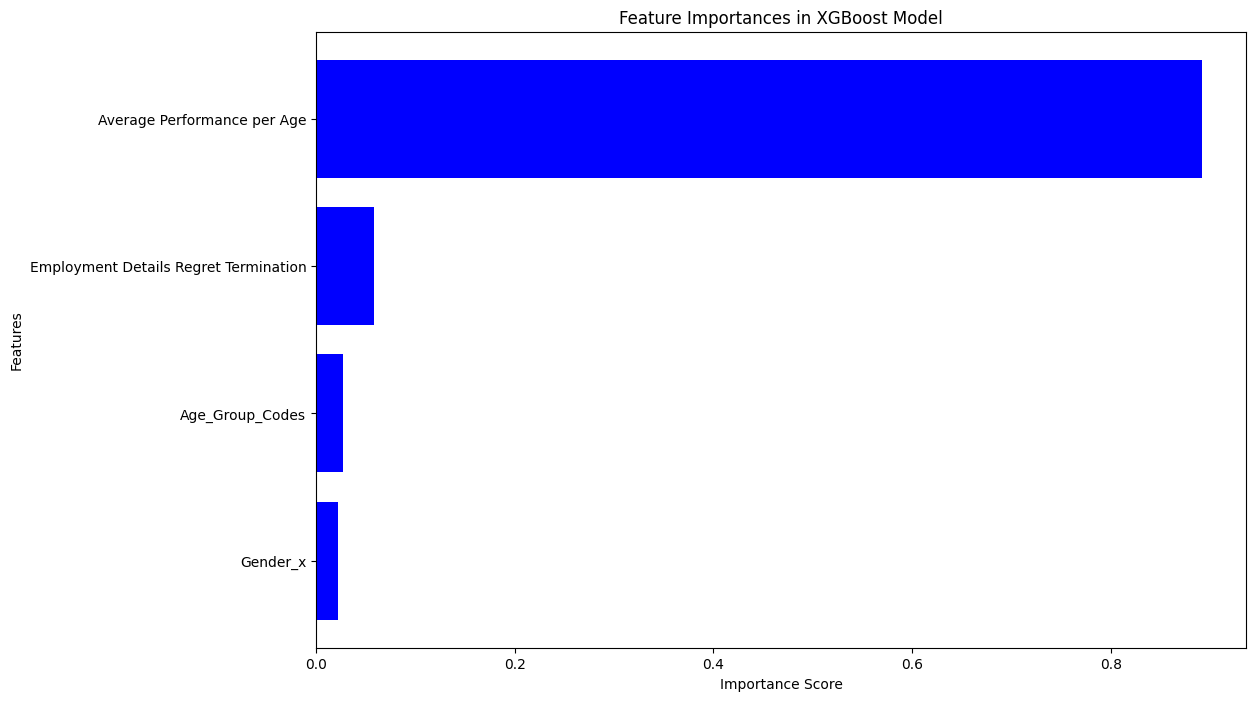

In [74]:
import matplotlib.pyplot as plt
import pandas as pd

best_xgboost_classifier = best_xgboost_model_xgb.named_steps['classifier']

# Extracting feature importances
feature_importances_xgb = best_xgboost_classifier.feature_importances_

# Creating a DataFrame to hold feature names and their importance scores
features_df_xgb = pd.DataFrame({
    'Feature': X_features_xgb, 
    'Importance': feature_importances_xgb
})

# Sorting the DataFrame by importance for better visualization
features_df_xgb = features_df_xgb.sort_values(by='Importance', ascending=False)

# Plotting feature importances
plt.figure(figsize=(12, 8))
plt.barh(features_df_xgb['Feature'], features_df_xgb['Importance'], color='blue')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.title('Feature Importances in XGBoost Model')
plt.gca().invert_yaxis()  
plt.show()


### Error Analysis

<Figure size 1920x1440 with 0 Axes>

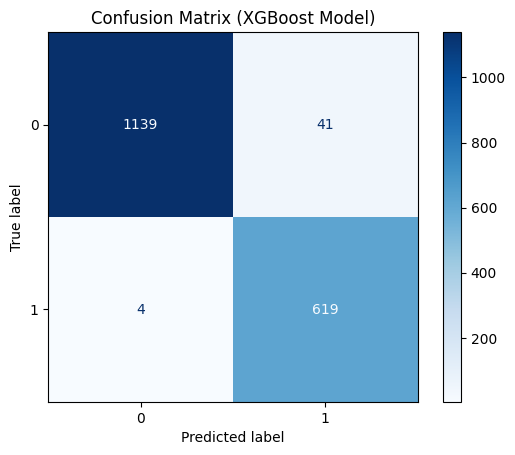

In [87]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


# Create confusion matrix
cm_xgb = confusion_matrix(y_test_xgb, test_pred_xgb)
plt.figure(dpi=300)
disp_xgb = ConfusionMatrixDisplay(confusion_matrix=cm_xgb)

# Plot confusion matrix
disp_xgb.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix (XGBoost Model)')
plt.show()

### SHAP values analysis

[23:33:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead


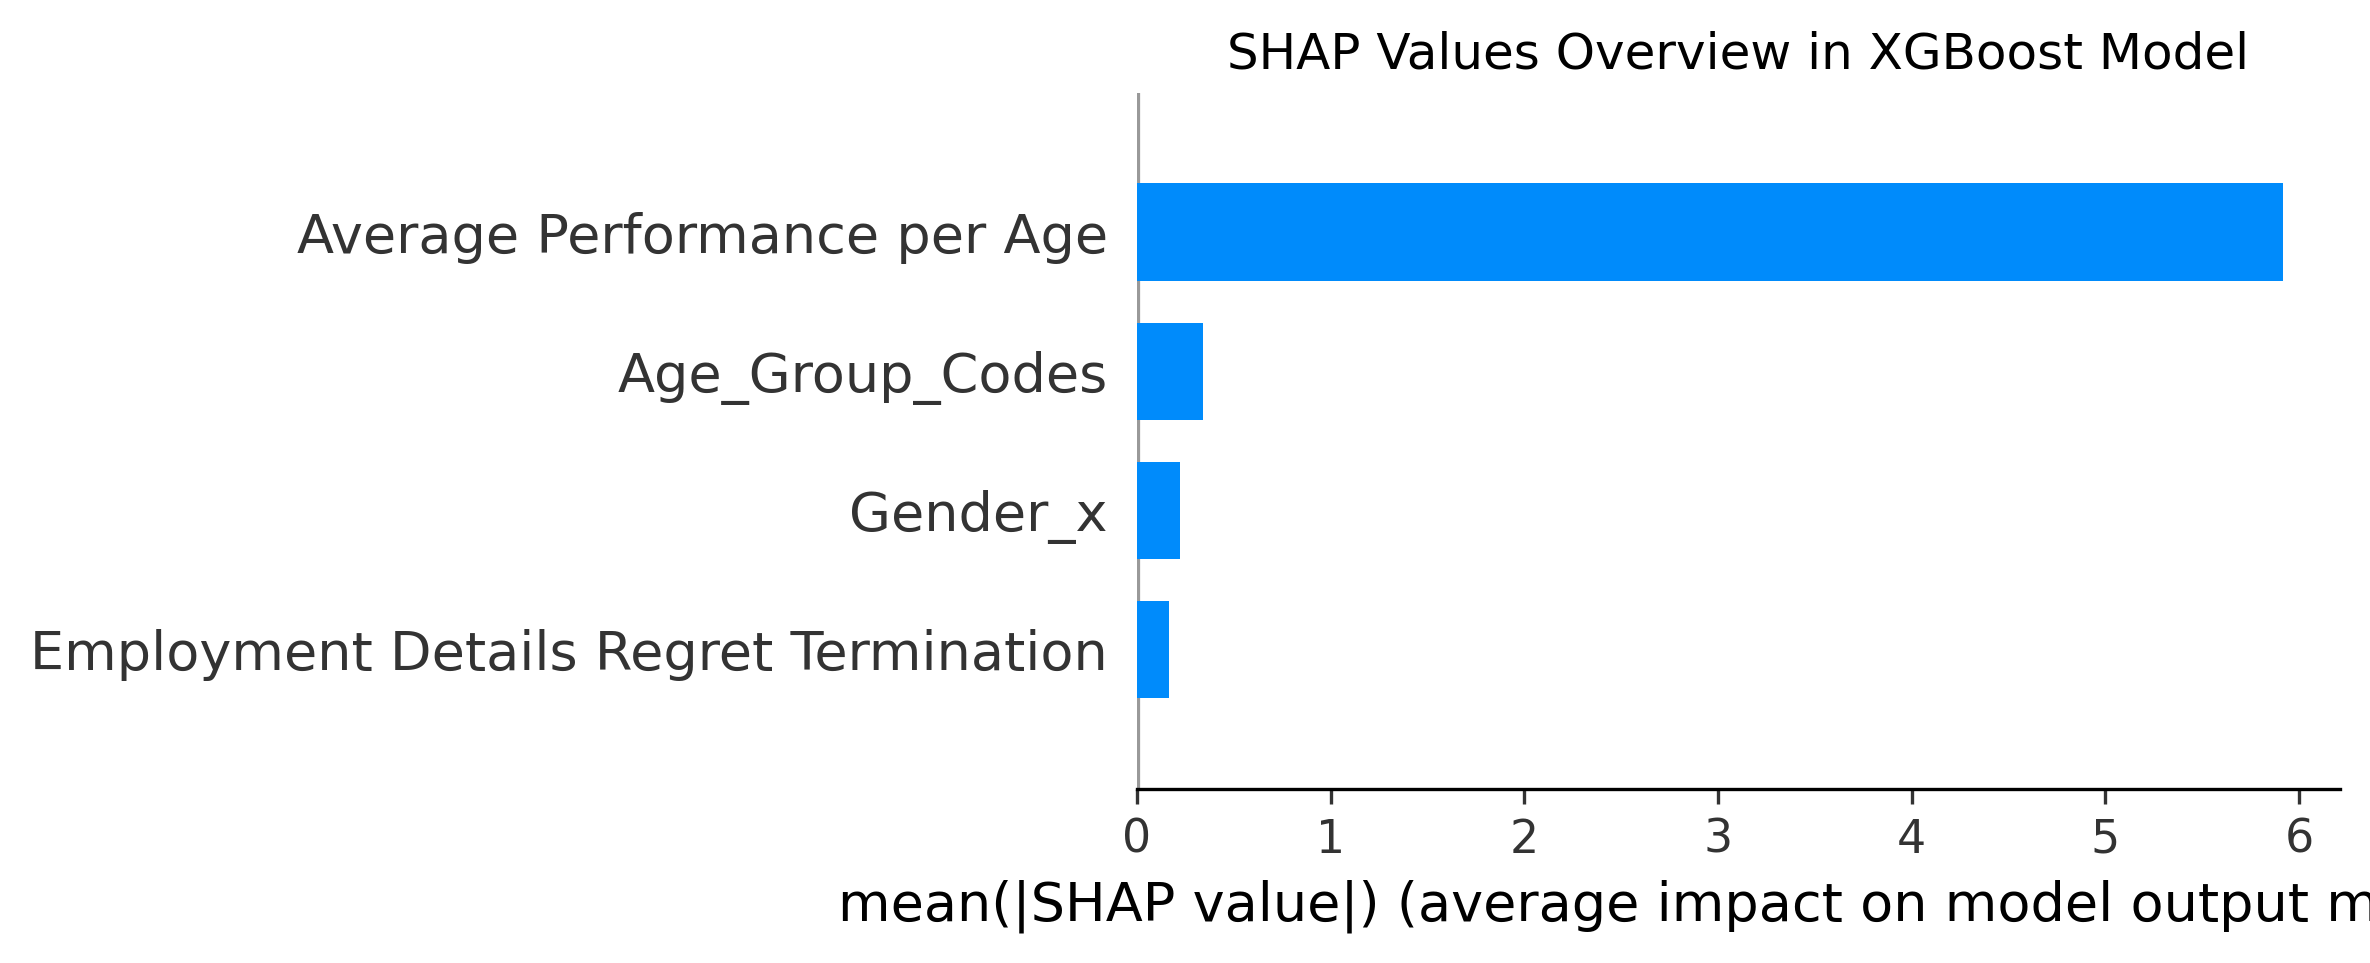

In [95]:
import shap
import matplotlib.pyplot as plt

# Create a SHAP explainer object
explainer = shap.Explainer(best_xgboost_classifier)

# Calculate SHAP values for the test set
shap_values = explainer.shap_values(X_test_xgb)

# Plot summary of SHAP values for all features across all samples
plt.figure(dpi=300)
shap.summary_plot(shap_values, X_test_xgb, plot_type="bar", feature_names=X_features_xgb, max_display=X_test_xgb.shape[1], show=False)
plt.title('SHAP Values Overview in XGBoost Model') 
plt.show()


### Robustness checks 

#### Adding noise with resampling

In [62]:
from sklearn.utils import resample
import numpy as np
from sklearn.metrics import classification_report, f1_score, cohen_kappa_score
import pandas as pd
from xgboost import XGBClassifier

# Function to add Gaussian noise
def add_noise_xgb(data, noise_level=0.1):
    noise_xgb = np.random.randn(*data.shape) * noise_level
    return data + noise_xgb

# Number of bootstrap samples
bootstrap_samples_xgb = 100
f1_scores_xgb = []
f1_scores_train_xgb = []  # List to store F1 scores for training data in each bootstrap sample
classification_reports_xgb = []
kappa_scores_xgb = []  # To store Cohen's Kappa scores

# Initialize XGBoost Classifier
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

for _ in range(bootstrap_samples_xgb):
    # Resampling with replacement
    X_resampled_xgb, y_resampled_xgb = resample(X_train_xgb, y_train_xgb)
    
    # Add Gaussian noise to the resampled data
    X_xgb_resampled_noisy = add_noise_xgb(X_resampled_xgb)

    # Fit the XGBoost model on the noisy resampled data
    xgb_model.fit(X_xgb_resampled_noisy, y_resampled_xgb)

    # Predict on the noisy resampled training data to evaluate training performance
    y_train_pred_xgb = xgb_model.predict(X_xgb_resampled_noisy)
    f1_train_score_xgb = f1_score(y_resampled_xgb, y_train_pred_xgb)
    f1_scores_train_xgb.append(f1_train_score_xgb)

    # Predict on the original, clean test set
    y_pred_xgb = xgb_model.predict(X_test_xgb)
    
    # Calculate the F1 score and store it
    score_xgb = f1_score(y_test_xgb, y_pred_xgb)
    f1_scores_xgb.append(score_xgb)
    
    # Generate and store the classification report
    report_xgb = classification_report(y_test_xgb, y_pred_xgb, output_dict=True)
    classification_reports_xgb.append(report_xgb)

    # Calculate and store Cohen's Kappa
    kappa_xgb = cohen_kappa_score(y_test_xgb, y_pred_xgb)
    kappa_scores_xgb.append(kappa_xgb)

# Calculate and print the average F1 score across all bootstrap samples
average_f1_score_xgb_noisy = np.mean(f1_scores_xgb)
print("Average F1 Score on noisy resampled data:", average_f1_score_xgb_noisy)
print("Average F1 Score on Training Data (noisy resampled):", np.mean(f1_scores_train_xgb))

# Calculate and print the average Cohen's Kappa score
average_kappa_score_xgb_noisy = np.mean(kappa_scores_xgb)
print("Average Cohen's Kappa Score on noisy resampled data:", average_kappa_score_xgb_noisy)

# Combine all classification reports into a single DataFrame for averaging
df_reports_xgb_noisy = pd.DataFrame(classification_reports_xgb)

# Aggregate classification reports by averaging each metric
average_report_xgb_noisy = df_reports_xgb_noisy.apply(lambda col: pd.DataFrame(col.tolist()).mean()).to_dict()

# Print the average classification report
print("\nAverage Classification Report on Noisy Resampled Data:\n")
print(pd.DataFrame(average_report_xgb_noisy).transpose())


is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecat

Average F1 Score on noisy resampled data: 0.2362663101690171
Average F1 Score on Training Data (noisy resampled): 0.7598073003278445
Average Cohen's Kappa Score on noisy resampled data: 0.09594654939872037

Average Classification Report on Noisy Resampled Data:

                     0  f1-score  precision    recall  support
0                  NaN  0.772979   0.678623  0.906644   1180.0
1                  NaN  0.236266   0.572350  0.177817    623.0
accuracy      0.654809       NaN        NaN       NaN      NaN
macro avg          NaN  0.504623   0.625486  0.542231   1803.0
weighted avg       NaN  0.587526   0.641902  0.654809   1803.0


#### Stratified cross-validation

In [63]:
#  Cross-Validation with Stratification
from sklearn.model_selection import StratifiedKFold

str = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
scores_str_xgb = []

for train_idx, test_idx in str.split(X_xgb, y_xgb):
    X_train_str_xgb, X_test_str_xgb = X_xgb.iloc[train_idx], X_xgb.iloc[test_idx]
    y_train_str_xgb, y_test_str_xgb = y_xgb.iloc[train_idx], y_xgb.iloc[test_idx]
    
    best_xgboost_model_xgb.fit(X_train_str_xgb, y_train_str_xgb)
    y_pred_str_xgb = best_xgboost_model_xgb.predict(X_test_str_xgb)
    scores_str_xgb.append(f1_score(y_test_str_xgb, y_pred_str_xgb))

print("F1 Scores across stratified folds:", scores_str_xgb)

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecat

F1 Scores across stratified folds: [0.9738562091503269, 0.9675324675324676, 0.9642857142857142, 0.9692058346839547, 0.9754500818330606, 0.9769736842105263, 0.9642857142857142, 0.9834983498349835, 0.9590834697217676, 0.9642857142857142]


is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead


In [64]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, f1_score, cohen_kappa_score
import numpy as np
import pandas as pd
from xgboost import XGBClassifier

# Initialize StratifiedKFold
str_kfold_xgb = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Initialize XGBoost Classifier
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

f1_scores_xgb_str = []
f1_scores_train_xgb_str = [] 
classification_reports_xgb_str = []
kappa_scores_xgb_str = []  

# Perform cross-validation with stratification
for train_idx, test_idx in str_kfold_xgb.split(X_xgb, y_xgb):
    X_train_str_xgb, X_test_str_xgb = X_xgb.iloc[train_idx], X_xgb.iloc[test_idx]
    y_train_str_xgb, y_test_str_xgb = y_xgb.iloc[train_idx], y_xgb.iloc[test_idx]
    
    # Fit the XGBoost model on the stratified training data
    xgb_model.fit(X_train_str_xgb, y_train_str_xgb)

    # Predict on the training data to evaluate training performance
    y_train_pred_xgb = xgb_model.predict(X_train_str_xgb)
    f1_train_score_xgb = f1_score(y_train_str_xgb, y_train_pred_xgb)
    f1_scores_train_xgb_str.append(f1_train_score_xgb)

    # Predict on the stratified test set
    y_pred_str_xgb = xgb_model.predict(X_test_str_xgb)

    # Calculate the F1 score for the current fold and append to the list
    f1_scores_xgb_str.append(f1_score(y_test_str_xgb, y_pred_str_xgb))
    
    # Generate and store the classification report for the current fold
    report_str_xgb = classification_report(y_test_str_xgb, y_pred_str_xgb, output_dict=True)
    classification_reports_xgb_str.append(report_str_xgb)

    # Calculate and store Cohen's Kappa for the current fold
    kappa_str_xgb = cohen_kappa_score(y_test_str_xgb, y_pred_str_xgb)
    kappa_scores_xgb_str.append(kappa_str_xgb)

# Print the average F1 score across all stratified folds
average_f1_score_str_xgb = np.mean(f1_scores_xgb_str)
print("Average F1 Score across stratified folds:", average_f1_score_str_xgb)
print("Average F1 Score on Training Data across stratified folds:", np.mean(f1_scores_train_xgb_str))

# Print the average Cohen's Kappa score across all folds
average_kappa_score_str_xgb = np.mean(kappa_scores_xgb_str)
print("Average Cohen's Kappa Score across stratified folds:", average_kappa_score_str_xgb)

# Calculate the average classification report
def average_classification_report_xgb_str(reports):
    # Convert list of dicts into DataFrame for each 'macro avg' key
    report_df = pd.DataFrame.from_records([report['macro avg'] for report in reports])
    # Calculate mean for each column
    return report_df.mean()

# Calculate and display the average classification report
avg_report_xgb_str = average_classification_report_xgb_str(classification_reports_xgb_str)
print("\nAverage Classification Report on Stratified Cross-Validation Data:\n", avg_report_xgb_str)

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecat

Average F1 Score across stratified folds: 0.9682445685374178
Average F1 Score on Training Data across stratified folds: 0.9697359515526663
Average Cohen's Kappa Score across stratified folds: 0.9519747757420743

Average Classification Report on Stratified Cross-Validation Data:
 precision      0.971129
recall         0.981453
f1-score       0.975981
support      901.200000
dtype: float64
